#Introduction

In this notebook, the analysis was conducted on the 60,000 compounds from the assay...

The data for this table was downloaded from here: https://colab.research.google.com/drive/1rtv74PXgeY1Zxldul6Cp1PZNhV2H1e3r?usp=sharing

Assay data:

https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301569/

https://pubchem.ncbi.nlm.nih.gov/bioassay/1159505

All showed an IC50 greater than the tested value (2.5 uM). Therefore, they are considered inactive.

What was done:
- Visualization of compound structures
- Analysis of the assays
- Determination of activity/inactivity based on pchembl IC50
- Determination of activity based on the assay
- Distribution of results
- Verification of similar structures (fingerprints, Tanimoto)
- PCA similarity analysis (active compounds)
- Selection of negative molecules similar to the clusters

CSV files needed:
- Lys_activities_CHEMBL5575.csv
- Lys_activities_CHEMBL3301561.csv
- AID_1671156_datatable_all(IC50).csv


- ASSAY 5575 WAS ON HUMAN TARGET
- ASSAY 3301561 WAS ON PLASMODIUM TARGET

# Library installation

In [ ]:
# Instalar las librerias
!pip install pandas rdkit tqdm chembl_webresource_client git+https://github.com/ikmckenz/adme-pred-py.git

  Cloning https://github.com/ikmckenz/adme-pred-py.git to /tmp/pip-req-build-2zhu9f2u
  Running command git clone --filter=blob:none --quiet https://github.com/ikmckenz/adme-pred-py.git /tmp/pip-req-build-2zhu9f2u
  Resolved https://github.com/ikmckenz/adme-pred-py.git to commit 8091a02fe5998b8ba237760ade7ff3400abbbcdd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 6.5 MB/s eta 0:00:00
  Created wheel for adme-pred: filename=adme_pred-0.0.2-py3-none-any.whl size=18560 sha256=68fdc4754e9d30d36a252567835a97f5cb0fcf642a7917ba980738710c56281f
  Stored in directory: /tmp/pip-ephem-wheel-cache-07glk_yg/wheels/0b/cd/8f/5b6314f4393bde6a8e1378ff709adf4c3a59e4ee2f4ef88256
Successfully built adme-pred
  Attempting uninstall: attrs
    Found existing installation: attrs 23.1.0
    Uninst

# Imports

In [ ]:
# Importar libreria de RDKit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors

# Importar libreria para cambiar el directorio y guardar archivos
import os

# Importar libreria para ver una barra con el progreso de cada comando
from tqdm.auto import tqdm
tqdm.pandas()

import pandas as pd

from chembl_webresource_client.new_client import new_client

# Importar libreria de ADME
from adme_pred import ADME

# Importar las librerias para graficar
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns

# Importar las funciones de 'sklearn'
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# Cargar el contenido de drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Indicar la carpeta de trabajo
path_luz = '/content/drive/MyDrive/Proyecto análisis Lysil tRNA Sintetasa/Analisis_compuestos/Activos_contra_Lys'
path_mer = '/content/drive/Shareddrives/Doctorado/Proyecto análisis Lysil tRNA Sintetasa/Analisis_compuestos/Activos_contra_Lys'
os.chdir(path_luz)

Data was taken from this file: https://colab.research.google.com/drive/1rtv74PXgeY1Zxldul6Cp1PZNhV2H1e3r?usp=sharing

In [ ]:
#dataframe with essay 5575- human assay
df_CHEMBL5575= pd.read_csv('Lys_activities_CHEMBL5575.csv',sep=  ',')

print("Target CHEMBL5575 is Lysyl-tRNA synthetase from Human")
print("This target has ",len(df_CHEMBL5575)," rows")

#dataframe with essay 3301561- plasmodium assay
df_CHEMBL3301561 = pd.read_csv('Lys_activities_CHEMBL3301561.csv',sep=  ',', low_memory=False)

print("Target CHEMBL3301561 is Lysyl-tRNA synthetase from Plasmodium falciparum (isolate 3D7)")
print("This target has ",len(df_CHEMBL3301561)," rows")

Target CHEMBL5575 is Lysyl-tRNA synthetase from Human
This target has  184  rows
Target CHEMBL3301561 is Lysyl-tRNA synthetase from Plasmodium falciparum (isolate 3D7)
This target has  69390  rows


Along this essay 60.000 compounds were tested.

In [ ]:
print(df_CHEMBL3301561.columns)
df_CHEMBL3301561

Index(['Unnamed: 0', 'action_type', 'activity_comment', 'activity_id',
       'activity_properties', 'assay_chembl_id', 'assay_description',
       'assay_type', 'assay_variant_accession', 'assay_variant_mutation',
       'bao_endpoint', 'bao_format', 'bao_label', 'canonical_smiles',
       'data_validity_comment', 'data_validity_description',
       'document_chembl_id', 'document_journal', 'document_year',
       'ligand_efficiency', 'molecule_chembl_id', 'molecule_pref_name',
       'parent_molecule_chembl_id', 'pchembl_value', 'potential_duplicate',
       'qudt_units', 'record_id', 'relation', 'src_id', 'standard_flag',
       'standard_relation', 'standard_text_value', 'standard_type',
       'standard_units', 'standard_upper_value', 'standard_value',
       'target_chembl_id', 'target_organism', 'target_pref_name',
       'target_tax_id', 'text_value', 'toid', 'type', 'units', 'uo_units',
       'upper_value', 'value'],
      dtype='object')


,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,0,NaN,NaN,14807952,[],CHEMBL3301569,MMV: KRS recombinant Plasmodium falciparum Lys...,F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,2.5
1,1,NaN,NaN,14807953,[],CHEMBL3301569,MMV: KRS recombinant Plasmodium falciparum Lys...,F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,2.5
2,2,NaN,NaN,14807954,[],CHEMBL3301569,MMV: KRS recombinant Plasmodium falciparum Lys...,F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,2.5
3,3,NaN,NaN,14807955,[],CHEMBL3301569,MMV: KRS recombinant Plasmodium falciparum Lys...,F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,2.5
4,4,NaN,NaN,14807956,[],CHEMBL3301569,MMV: KRS recombinant Plasmodium falciparum Lys...,F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69385,69385,NaN,NaN,22068982,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,pIC50,NaN,UO_0000065,NaN,4.3
69386,69386,NaN,NaN,22068983,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,pIC50,NaN,UO_0000065,NaN,4.3
69387,69387,NaN,NaN,22068984,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,pIC50,NaN,UO_0000065,NaN,4.3
69388,69388,NaN,NaN,22068985,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,Plasmodium falciparum (isolate 3D7),Lysine--tRNA ligase,36329,NaN,NaN,pIC50,NaN,UO_0000065,NaN,4.3


# Adding Inchikey and delete duplicates

In [ ]:
#HUMAN DATA
mol_list = [Chem.MolFromSmiles(smiles) for smiles in df_CHEMBL5575["canonical_smiles"]]
df_CHEMBL5575["ROMol"] = mol_list
inchikey_list = [Chem.MolToInchiKey(mol) for mol in mol_list]
df_CHEMBL5575["InchiKey"] = inchikey_list

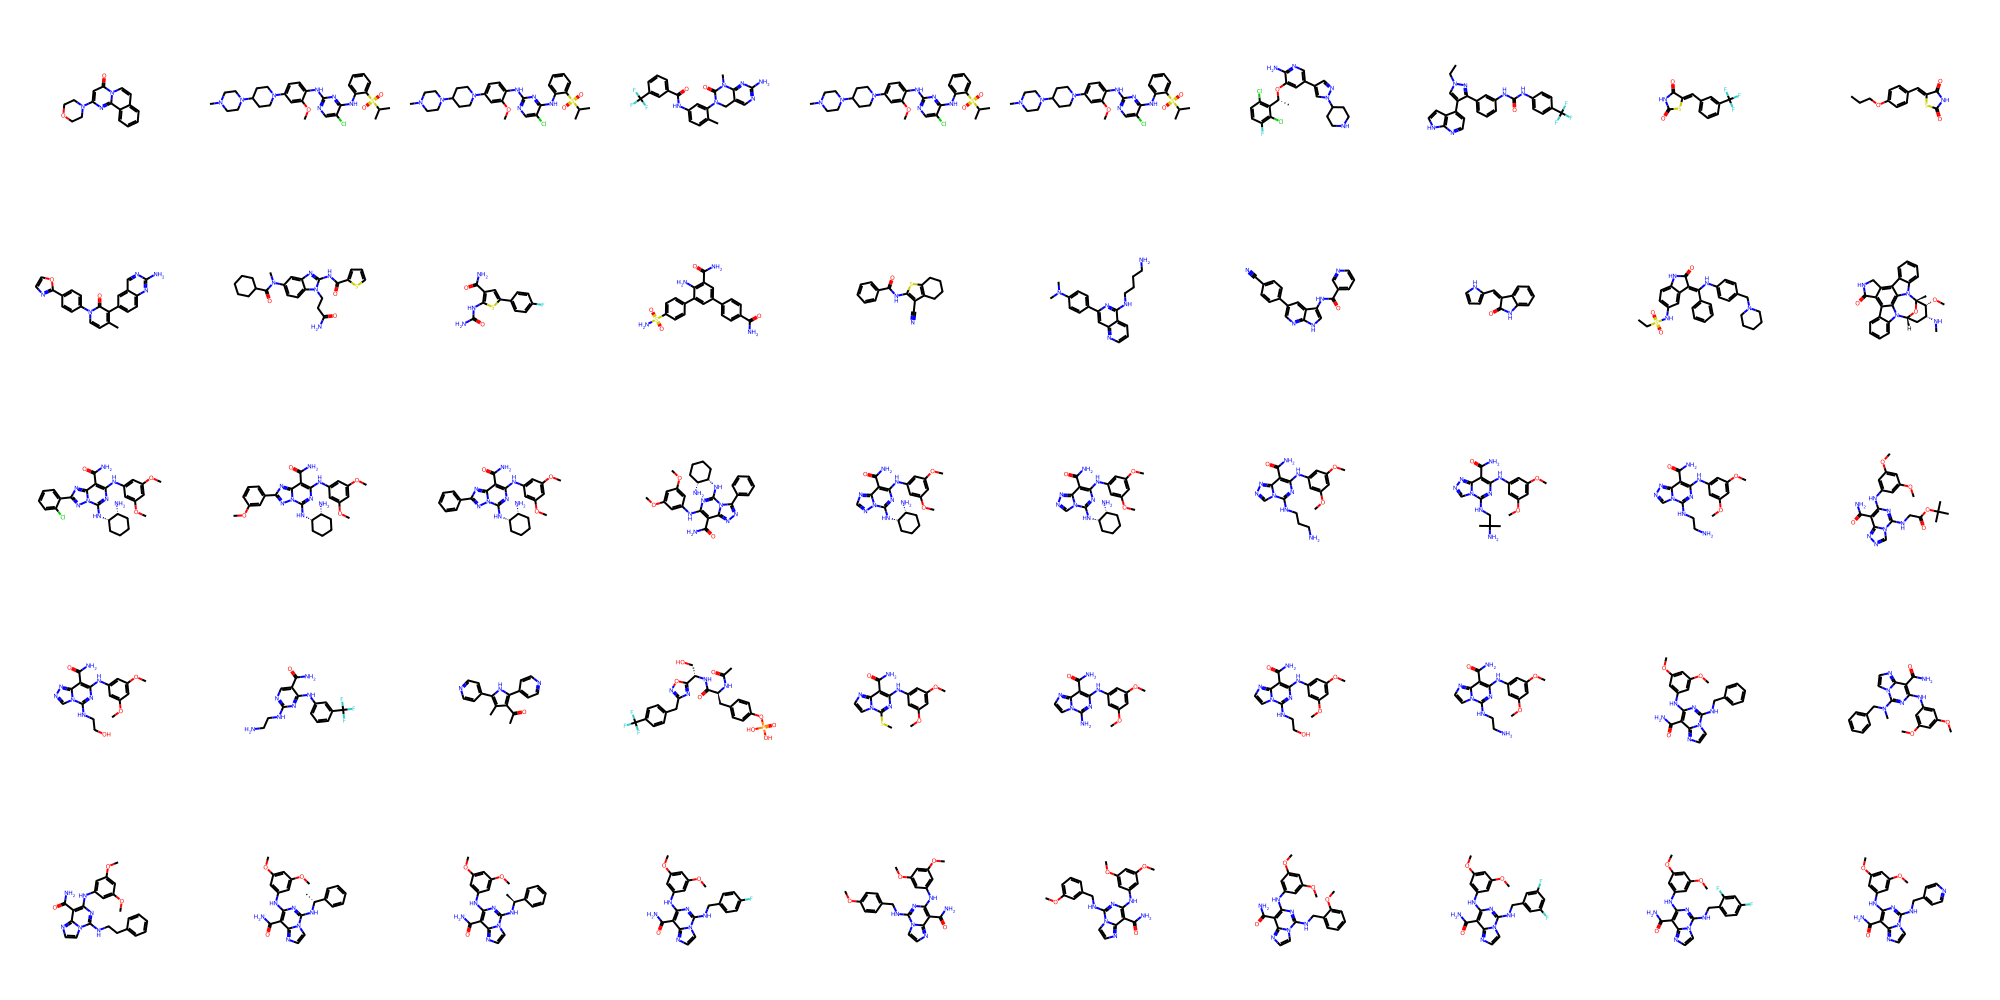

In [ ]:
Chem.Draw.MolsToGridImage(df_CHEMBL5575.ROMol,molsPerRow=10) #HUMAN ASSAY

In [ ]:
#smiles analysis
for i in range(len(df_CHEMBL5575)):
  print(df_CHEMBL5575["canonical_smiles"][i])

O=c1cc(N2CCOCC2)nc2c3ccccc3ccn12
COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1Cc2cnc(N)nc2N(C)C1=O
COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(Nc2ccccc2S(=O)(=O)C(C)C)n1
C[C@@H](Oc1cc(-c2cnn(C3CCNCC3)c2)cnc1N)c1c(Cl)ccc(F)c1Cl
CCn1cc(-c2ccnc3[nH]ccc23)c(-c2cccc(NC(=O)Nc3ccc(C(F)(F)F)cc3)c2)n1
O=C1NC(=O)/C(=C/c2cccc(C(F)(F)F)c2)S1
CCCOc1ccc(/C=C2\SC(=O)NC2=O)cc1
Cc1ccn(-c2ccc(-c3ncco3)cc2)c(=O)c1-c1ccc2nc(N)ncc2c1
CN(C(=O)C1CCCCC1)c1ccc2c(c1)nc(NC(=O)c1cccs1)n2CCC(N)=O
NC(=O)Nc1sc(-c2ccc(F)cc2)cc1C(N)=O
NC(=O)c1ccc(-c2cc(C(N)=O)c(N)c(-c3ccc(S(N)(=O)=O)cc3)c2)cc1
N#Cc1c(NC(=O)c2ccccc2)sc2c1CCCC2
CN(C)c1ccc(-c2cc3ncccc3c(NCCCCN)n2)cc1
N#Cc1ccc(-c2cnc3[nH]cc(NC(=O)c4cccnc4)c3c2)cc1
O=C1Nc2ccccc2/C1=C/c1ccc[nH]1
CCS(=O)(=O)Nc1ccc2c(c1)/C(=C(/Nc1ccc(CN3CCCCC3)cc1)c1ccccc1)C(=O)N2
CN[C@@

In [ ]:
#PLASMODIUM ASSAY
mol_list = []
inchikey_list = []
for i in range(len(df_CHEMBL3301561)):
  try:
    mol = Chem.MolFromSmiles(df_CHEMBL3301561["canonical_smiles"][i])
    mol_list.append(mol)
    inchikey = Chem.MolToInchiKey(mol)
    inchikey_list.append(inchikey)
  except:
    print(i)
    mol_list.append("NaN")
    inchikey_list.append("NaN")

df_CHEMBL3301561["ROMol"] = mol_list
df_CHEMBL3301561["InchiKey"] = inchikey_list

1453


In [ ]:
df_CHEMBL3301561["InchiKey"].value_counts()

TZKIHRGKZAFBDI-UHFFFAOYSA-N    2
WOMKDMUZNBFXKG-JIMOISOXSA-N    2
OLASVPYHZCKOTK-UHFFFAOYSA-N    2
WOMKDMUZNBFXKG-WQAKAFBOSA-N    2
QBGWDBKTUNINNZ-UHFFFAOYSA-N    2
                              ..
MHDQXBXLEDSCGL-UHFFFAOYSA-N    1
GYLIFXIIMPBYQU-UHFFFAOYSA-N    1
VHMACAXRCZMIPI-UHFFFAOYSA-N    1
ILCPYXPJFUNXPI-UHFFFAOYSA-N    1
FTUGDXNZORMDBC-UHFFFAOYSA-N    1
Name: InchiKey, Length: 69022, dtype: int64

# Distribution visualization

##  Human chembl5575  

In [ ]:
df_CHEMBL5575["standard_type"].value_counts()

IC50          128
Activity       26
Inhibition     14
Delta Tm        8
Ki              3
Kd              3
EC50            2
Name: standard_type, dtype: int64

<Axes: xlabel='count', ylabel='standard_type'>

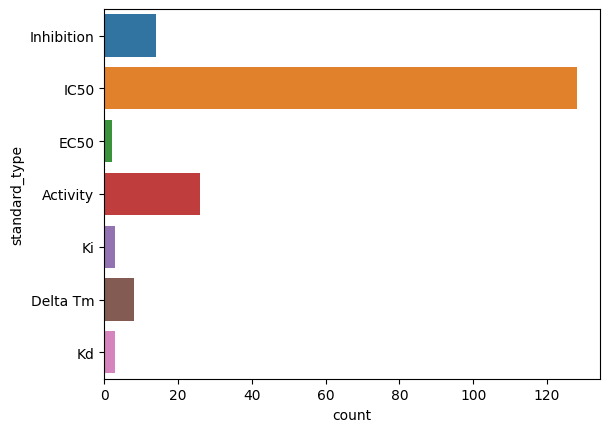

In [ ]:
sns.countplot(data=df_CHEMBL5575, y="standard_type")

###Wihtout pchembl

In the ChEMBL database, "pChEMBL" refers to the negative logarithm base 10 of the half-maximal inhibitory concentration (IC50), which is a measure of the biological activity of a compound. The relationship between the concentration of a compound and its biological effect is commonly expressed as the negative logarithm of the half-maximal inhibitory concentration, known as pIC50 or pChEMBL

In [ ]:
sinpchembl=df_CHEMBL5575[df_CHEMBL5575.pchembl_value.isnull()]
sinpchembl

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ROMol,InchiKey
0,0,NaN,NaN,2182836,[],CHEMBL941462,Inhibition of SYK at 5 uM,B,NaN,NaN,...,9606,NaN,NaN,INH,%,UO_0000187,NaN,14.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0eb90>,BVRDQVRQVGRNHG-UHFFFAOYSA-N
2,2,NaN,NaN,2198022,[],CHEMBL1006352,Inhibition of Syk kinase,B,NaN,NaN,...,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,286.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0ee30>,QQWUGDVOUVUTOY-UHFFFAOYSA-N
6,6,NaN,NaN,2206990,[],CHEMBL990563,Inhibition of Syk,B,NaN,NaN,...,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,10.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0eff0>,KTEIFNKAUNYNJU-GFCCVEGCSA-N
7,7,NaN,Not Active,2240602,[],CHEMBL972665,Inhibition of SYK at 30 uM,B,NaN,NaN,...,9606,NaN,NaN,Activity,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f060>,XMVDDSSINBJQNA-UHFFFAOYSA-N
8,8,NaN,NaN,2248299,[],CHEMBL957364,Inhibition of SYK at 5 uM,B,NaN,NaN,...,9606,NaN,NaN,INH,%,UO_0000187,NaN,5.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0e490>,NGJLOFCOEOHFKQ-YVMONPNESA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,175,NaN,NaN,18706769,[],CHEMBL4256117,Inhibition of SYK (unknown origin) at 50 ug/ml...,B,NaN,NaN,...,9606,NaN,NaN,INH,%,UO_0000187,NaN,81.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b13290>,NFWKVWVWBFBAOV-MISYRCLQSA-N
178,178,NaN,NaN,19371161,[],CHEMBL4424913,Inhibition of human N-terminal His6-tagged SYK...,A,NaN,NaN,...,9606,NaN,NaN,IC50,nM,UO_0000065,NaN,1000.0,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b133e0>,LTTJGQBDGMNWHJ-SANMLTNESA-N
179,179,NaN,Active,20638329,[],CHEMBL4612404,Binding affinity to Lysine-tRNA ligase in huma...,B,NaN,NaN,...,9606,NaN,NaN,Activity,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b13450>,PEMUGDMSUDYLHU-ZEQRLZLVSA-N
182,182,"{'action_type': 'INHIBITOR', 'description': 'N...",Active,23217172,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4823986,Binding affinity to human N-terminal His6-tagg...,B,NaN,NaN,...,9606,NaN,NaN,Activity,NaN,NaN,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b135a0>,PMAMDXBXQJIVJC-BWAHOGKJSA-N


In [ ]:
sinpchembl["standard_type"].value_counts()

IC50          30
Activity      26
Inhibition    14
Delta Tm       8
Ki             2
Name: standard_type, dtype: int64

Assays distribution

<Axes: xlabel='count', ylabel='standard_type'>

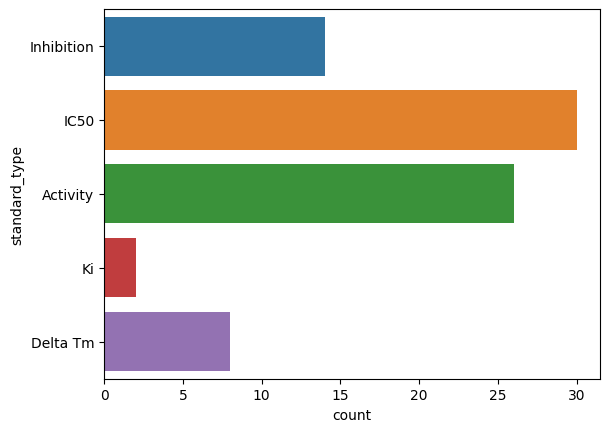

In [ ]:
sns.countplot(data=sinpchembl, y="standard_type")

In [ ]:
IC50_sinpchembl=sinpchembl[sinpchembl.standard_type=="IC50"].reset_index() #hay 30
print(len(IC50_sinpchembl))
Activity_sinpchembl= sinpchembl[sinpchembl.standard_type=="Activity"] #hay 26 pero 10 son nan y 11 no evaluados
print(len(Activity_sinpchembl))
Inhibition= sinpchembl[sinpchembl.standard_type=="Inhibition"]
print(len(Inhibition))
deltaTM=sinpchembl[sinpchembl.standard_type=="Delta Tm"]
print(len(deltaTM))
Ki= sinpchembl[sinpchembl.standard_type=="Ki"]
print(len(Ki))

30
26
14
8
2


IC50 distribution

Determination of activity/inactivity in each assay

array([[<Axes: title={'center': 'standard_value'}>]], dtype=object)

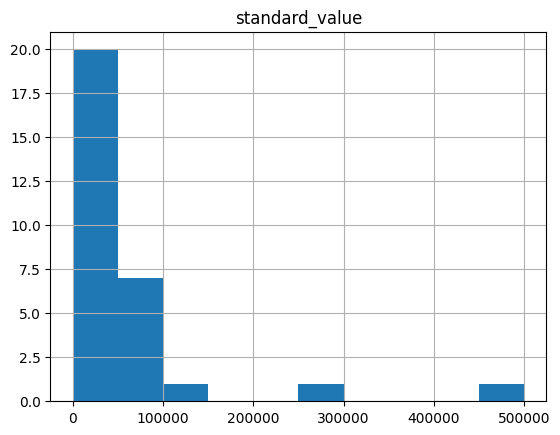

In [ ]:
IC50_sinpchembl.hist(column='standard_value')

IC50:

In [ ]:
#IC50
sinpchembl["standard_type"].value_counts()

IC50          30
Activity      26
Inhibition    14
Delta Tm       8
Ki             2
Name: standard_type, dtype: int64

In [ ]:
IC50_sinpchembl_igual=IC50_sinpchembl[IC50_sinpchembl.standard_relation=="="]
IC50_sinpchembl_mayor=IC50_sinpchembl[IC50_sinpchembl.standard_relation==">"]

In [ ]:
Activos_IC50_igual = IC50_sinpchembl_igual[IC50_sinpchembl_igual.standard_value<=5000]
# Activos_IC50_mayor = No hay porque no se encontró el IC50 en las concentraciones ensayadas

Inactivos_IC50_igual = IC50_sinpchembl_igual[IC50_sinpchembl_igual.standard_value>=10000]
Inactivos_IC50_mayor = IC50_sinpchembl_igual[IC50_sinpchembl_igual.standard_value>=10000]

In [ ]:
#Activity
print(Activity_sinpchembl["standard_type"].value_counts())
print(Activity_sinpchembl["activity_comment"].value_counts())

Activos_activity=Activity_sinpchembl[Activity_sinpchembl.activity_comment=="Active"] #4
print(Activos_activity["standard_type"].value_counts())
print(len(Activos_activity))

Inactivos_activity=Activity_sinpchembl[Activity_sinpchembl.activity_comment=="Not Active"] #2 total
print(Inactivos_activity["standard_type"].value_counts())
print(len(Inactivos_activity))

Not_Evaluated_activity=Activity_sinpchembl[Activity_sinpchembl.activity_comment=="Not Evaluated"] #2 total
print(Not_Evaluated_activity["standard_type"].value_counts())
print(len(Not_Evaluated_activity))

percent_Not_Evaluated_activity = Activity_sinpchembl[sinpchembl.units=="%"]
print(percent_Not_Evaluated_activity["standard_type"].value_counts())
print(len(percent_Not_Evaluated_activity))

Activity    26
Name: standard_type, dtype: int64
Not Evaluated    11
Active            4
Not Active        2
Name: activity_comment, dtype: int64
Activity    4
Name: standard_type, dtype: int64
4
Activity    2
Name: standard_type, dtype: int64
2
Activity    11
Name: standard_type, dtype: int64
11
Activity    9
Name: standard_type, dtype: int64
9


<ipython-input-20-e31ae4fd2487>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  percent_Not_Evaluated_activity = Activity_sinpchembl[sinpchembl.units=="%"]


In [ ]:
print(percent_Not_Evaluated_activity["assay_description"].value_counts())

Binding affinity to human SYK at 10 uM relative to control                                                                        6
Binding affinity to SYK at 1 uM                                                                                                   1
Inhibition of human SYK assessed as enzyme residual activity at 100 nM by radiometric filter binding assay relative to control    1
Inhibition of SYK (unknown origin) assessed as residual activity at 1 uM relative to control                                      1
Name: assay_description, dtype: int64


In [ ]:
#Inhibition
print(Inhibition["standard_type"].value_counts())

Activos_Inhibition = Inhibition[Inhibition.value>=75] #1 >75 are considered acives
print(Activos_Inhibition["standard_type"].value_counts())

Inactivos_Inhibition = Inhibition[Inhibition.value<=25] #9 <25 are considered inactives
print(Inactivos_Inhibition["standard_type"].value_counts())

Inhibition    14
Name: standard_type, dtype: int64
Inhibition    1
Name: standard_type, dtype: int64
Inhibition    9
Name: standard_type, dtype: int64


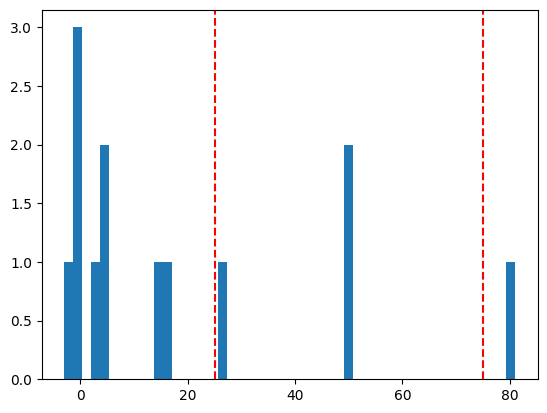

In [ ]:
import matplotlib.pyplot as plt


plt.hist(Inhibition['value'], bins=50)

plt.axvline(x=25, color='red', linestyle='--', label='valores negativos')
plt.axvline(x=75, color='red', linestyle='--', label='valores positivos')

# Muestra el histograma
plt.show()

DeltaTM:

In [ ]:
#deltaTM
#Sin procesar porque hay que mirar los datos uno por uno
print(deltaTM["assay_description"].value_counts())

Binding affinity to human KRS expressed in Escherichia coli BL21 by thermal shift assay    8
Name: assay_description, dtype: int64


Ki:

In [ ]:
#Ki
print(Ki["standard_type"].value_counts())

Activos_Ki=Ki[Ki.value<=5] #1 total: <5 are considered active
print(Activos_Ki["standard_type"].value_counts())

Inactivos_Ki=Ki[Ki.value>=10] #1 total: >10 are considered inactive
print(Inactivos_Ki["standard_type"].value_counts())

Ki    2
Name: standard_type, dtype: int64
Ki    1
Name: standard_type, dtype: int64
Ki    1
Name: standard_type, dtype: int64


In [ ]:
ACTIVOS_SINPCHEMBL= pd.concat([Activos_IC50_igual,Activos_activity,Activos_Inhibition,Activos_Ki]) #actives without pchembl
INACTIVOS_SINPCHEMBL=pd.concat([Inactivos_IC50_igual,Inactivos_IC50_mayor,Inactivos_activity,Inactivos_Inhibition,Inactivos_Ki]) #inacctives without pchembl

<Axes: xlabel='count', ylabel='standard_type'>

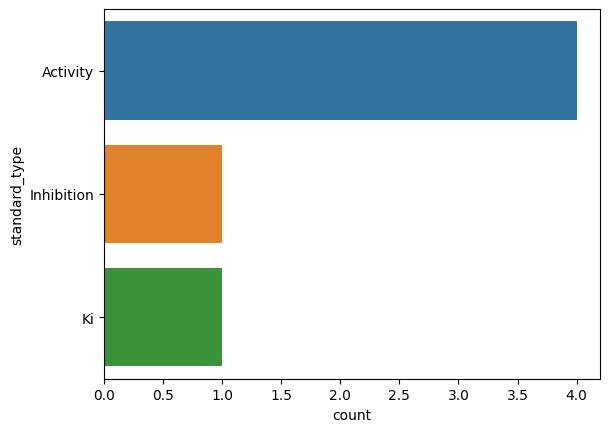

In [ ]:
#ACTIVES DISTRUBUTION WITHOUT PCHEMBL
sns.countplot(data=ACTIVOS_SINPCHEMBL, y="standard_type")

<Axes: xlabel='count', ylabel='standard_type'>

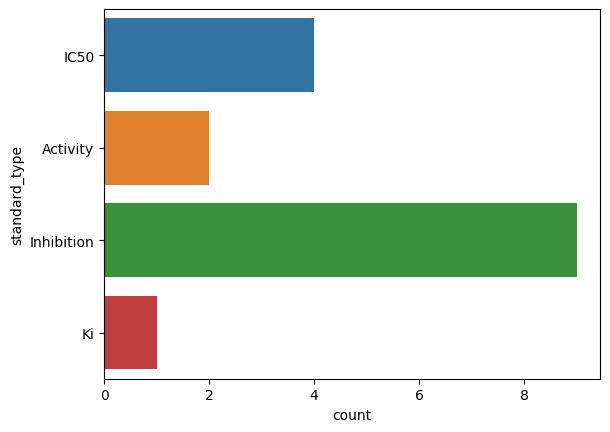

In [ ]:
#INACTIVES WITHOUT PCHEMBL
sns.countplot(data=INACTIVOS_SINPCHEMBL, y="standard_type")

###With pchembl

In [ ]:
conpchembl=df_CHEMBL5575[df_CHEMBL5575.pchembl_value.notnull()]
conpchembl=conpchembl.reset_index()
conpchembl.head(2)

,index,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ROMol,InchiKey
0,1,1,NaN,NaN,2198017,[],CHEMBL1006347,Inhibition of Tel-fused Syk kinase-mediated mo...,B,NaN,...,9606,NaN,NaN,IC50,uM,UO_0000065,NaN,1.474,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f1b0>,QQWUGDVOUVUTOY-UHFFFAOYSA-N
1,3,3,NaN,NaN,2206902,[],CHEMBL974011,Inhibition of Syk by cellular assay,B,NaN,...,9606,NaN,NaN,EC50,nM,UO_0000065,NaN,71.000,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0eea0>,ZWVLMQTXUWMUII-UHFFFAOYSA-N


Assay distribution

In [ ]:
print(conpchembl["standard_type"].value_counts())

IC50    98
Kd       3
EC50     2
Ki       1
Name: standard_type, dtype: int64


<Axes: xlabel='count', ylabel='standard_type'>

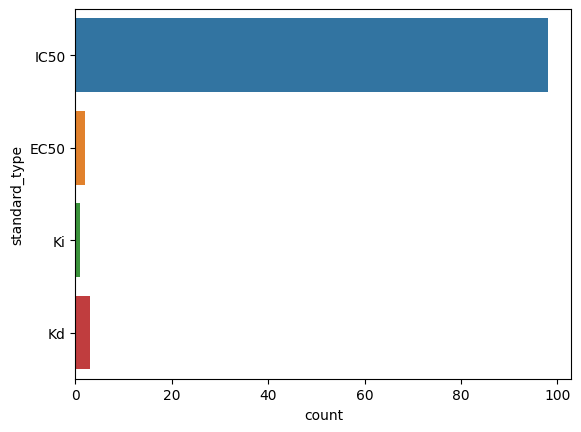

In [ ]:
sns.countplot(data=conpchembl, y="standard_type")

Determination of activity/inactivity in each assay

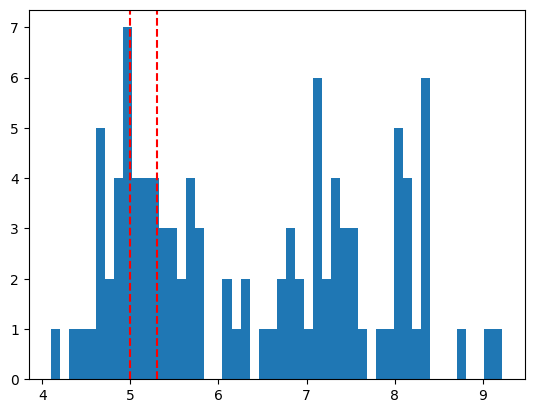

In [ ]:
import matplotlib.pyplot as plt

plt.hist(conpchembl["pchembl_value"], bins=50)  # Ajusta el número de bins según tu preferencia.

#with pchembl activity?inactivity values are around 5 and 5.3
plt.axvline(x=5, color='red', linestyle='--', label='valores negativos')
plt.axvline(x=5.3, color='red', linestyle='--', label='valores positivos')

# Muestra el histograma
plt.show()

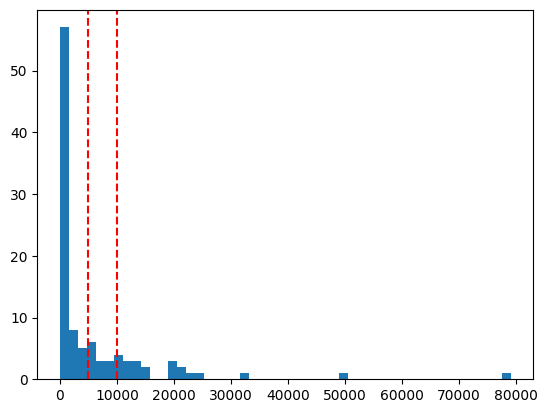

In [ ]:
import matplotlib.pyplot as plt


plt.hist(conpchembl["standard_value"], bins=50)

plt.axvline(x=5000, color='red', linestyle='--', label='valores positivos')
plt.axvline(x=10000, color='red', linestyle='--', label='valores negativos')

# Muestra el histograma
plt.show()

In [ ]:
Activos_conpchembl=conpchembl[conpchembl["pchembl_value"]>5.3] #72total. >5.3 are considered to be active
print(len(Activos_conpchembl))
Inactivos_conpchembl=conpchembl[conpchembl["pchembl_value"]<5] #18 total. <5 are considered to be inactive
print(len(Inactivos_conpchembl))

72
18


array([[<Axes: title={'center': 'standard_value'}>]], dtype=object)

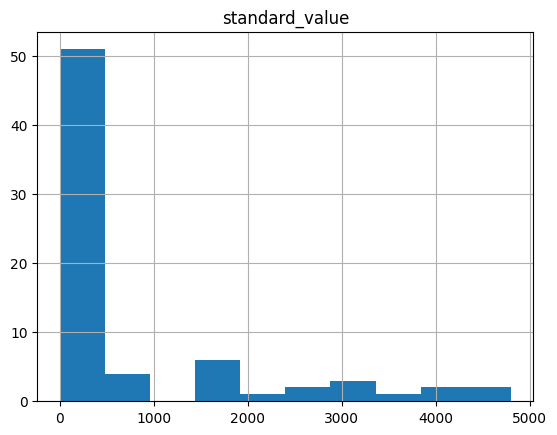

In [ ]:
#Active distribution
Activos_conpchembl.hist(column='standard_value')

array([[<Axes: title={'center': 'standard_value'}>]], dtype=object)

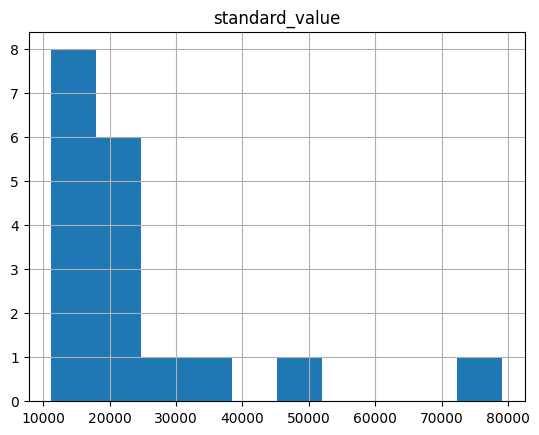

In [ ]:
#Inactive distribution
Inactivos_conpchembl.hist(column='standard_value')

In [ ]:
print(Activos_conpchembl["standard_type"].value_counts())

IC50    68
EC50     2
Ki       1
Kd       1
Name: standard_type, dtype: int64


In [ ]:
print(Inactivos_conpchembl["standard_type"].value_counts())

IC50    17
Kd       1
Name: standard_type, dtype: int64


In [ ]:
print(ACTIVOS_SINPCHEMBL["standard_type"].value_counts())

Activity      4
Inhibition    1
Ki            1
Name: standard_type, dtype: int64


human actives/inactives

In [ ]:
activos_humanos=pd.concat([Activos_conpchembl,ACTIVOS_SINPCHEMBL])
inactivos_humanos=pd.concat([Inactivos_conpchembl,INACTIVOS_SINPCHEMBL])

In [ ]:
print(len(Activos_conpchembl))
print(len(ACTIVOS_SINPCHEMBL))

72
6


## Plasmodium Chembl3301561

In [ ]:
print("The Dataframe has :",len(df_CHEMBL3301561), " rows")
print("Number of NaN rows per column:")
df_CHEMBL3301561.isnull().sum()

The Dataframe has : 69390  rows
Number of NaN rows per column:


Unnamed: 0                       0
action_type                  69390
activity_comment             69390
activity_id                      0
activity_properties              0
assay_chembl_id                  0
assay_description                0
assay_type                       0
assay_variant_accession      69390
assay_variant_mutation       69390
bao_endpoint                     0
bao_format                       0
bao_label                        0
canonical_smiles                 1
data_validity_comment        69390
data_validity_description    69390
document_chembl_id               0
document_journal             69374
document_year                  400
ligand_efficiency            69382
molecule_chembl_id               0
molecule_pref_name           69381
parent_molecule_chembl_id        0
pchembl_value                69371
potential_duplicate              0
qudt_units                       0
record_id                        0
relation                         0
src_id              

<Axes: xlabel='count', ylabel='standard_type'>

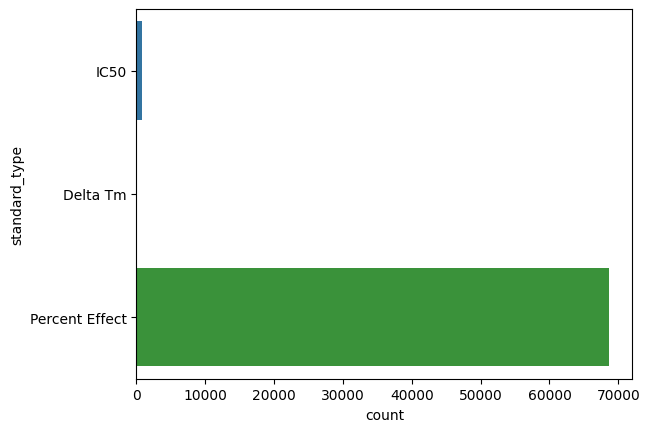

In [ ]:
#assays distribution
sns.countplot(data=df_CHEMBL3301561, y="standard_type")

###With pchembl

In [ ]:
conpchembl_plasmodium=df_CHEMBL3301561[df_CHEMBL3301561.pchembl_value.notnull()]

In [ ]:
print(conpchembl_plasmodium["standard_type"].value_counts())

IC50    19
Name: standard_type, dtype: int64


In [ ]:
conpchembl_plasmodium.head(2)

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ROMol,InchiKey
403,403,NaN,NaN,18530843,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,0.29,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32500>,WOMKDMUZNBFXKG-OASPWFOLSA-N
404,404,NaN,NaN,18530844,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,36329,NaN,NaN,IC50,uM,UO_0000065,NaN,0.12,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32570>,WOMKDMUZNBFXKG-ZWKOPEQDSA-N


Determination of activity/inactivity with pchembl

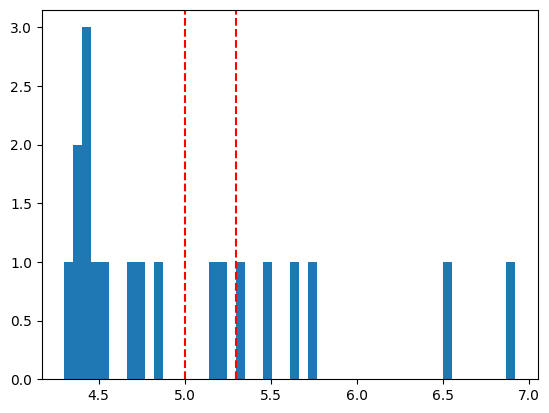

In [ ]:
plt.hist(conpchembl_plasmodium["pchembl_value"], bins=50)

#with pchembl activity?inactivity values are around 5 and 5.3
plt.axvline(x=5, color='red', linestyle='--', label='valores negativos')
plt.axvline(x=5.3, color='red', linestyle='--', label='valores positivos')

plt.show()

In [ ]:
print(len(conpchembl_plasmodium))
Activos_conpchembl_plasmodium=conpchembl_plasmodium[conpchembl_plasmodium["pchembl_value"]>5.3] #6 total actives
print(len(Activos_conpchembl_plasmodium))
Inactivos_conpchembl_plasmodium=conpchembl_plasmodium[conpchembl_plasmodium["pchembl_value"]<5] #11. total inactives
print(len(Inactivos_conpchembl_plasmodium))

19
6
11


###Without pchembl

In [ ]:
sinpchembl_plasmodium=df_CHEMBL3301561[df_CHEMBL3301561.pchembl_value.isnull()]

####Assays distribution

In [ ]:
print(sinpchembl_plasmodium["standard_type"].value_counts())

Percent Effect    68620
IC50                743
Delta Tm              8
Name: standard_type, dtype: int64


<Axes: xlabel='count', ylabel='standard_type'>

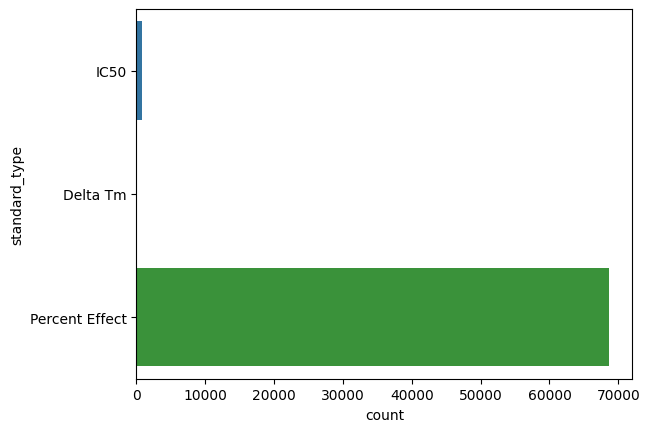

In [ ]:
sns.countplot(data=sinpchembl_plasmodium, y="standard_type")

Determination of activity/inactivity with another type of assay AID 1671156. This assay has different data and more accurate, but still the same amount and type of compounds

In [ ]:
ensayo = pd.read_csv("AID_1671156_datatable_all (IC50).csv",sep=',')

<ipython-input-52-e8bdb13cd62a>:1: DtypeWarning: Columns (0,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  ensayo = pd.read_csv("AID_1671156_datatable_all (IC50).csv",sep=',')


In [ ]:
ensayo

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,PubChem Standard Value,Standard Type,Standard Relation,Standard Value,Standard Units
0,RESULT_TYPE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FLOAT,STRING,STRING,FLOAT,STRING
1,RESULT_DESCR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PubChem standardized value transformed from 'S...,Standardized activity type (e.g. IC50 rather t...,"Qualifier (e.g. >, <, =) for 'Standard Value'",Standardized activity value transformed to com...,Selected units for 'Standard Type': e.g. conce...
2,RESULT_UNIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MICROMOLAR,NaN,NaN,NaN,NaN
3,RESULT_IS_ACTIVE_CONCENTRATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,NaN,NaN,NaN
4,RESULT_IS_ACTIVE_CONCENTRATION_QUALIFIER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRUE,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68974,68970,336856154.0,127024053.0,C1[C@@H]2CN(C[C@@H]2CN1CC3=CC(=CC=C3)C#N)C4=NC...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,4.745,%
68975,68971,336856155.0,127024054.0,CC1=NN=C(C=C1)N2CC[C@@H]([C@@H]2CC3=CN=CC=C3)O...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,3.275,%
68976,68972,336856156.0,127024055.0,C1CO[C@@H]2CN(C[C@@H]2CN1C3=NC=CC=N3)CC4=COC=C...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,5.037,%
68977,68973,336856157.0,127024056.0,CC1=CSC(=N1)NC(=O)[C@@H]2C[C@H]3[C@@H](O2)CCN3...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,2.058,%


In [ ]:

mol_list = []
inchikey_list = []
for i in range(len(ensayo)):
  try:
    mol = Chem.MolFromSmiles(ensayo["PUBCHEM_EXT_DATASOURCE_SMILES"][i])
    mol_list.append(mol)
    inchikey = Chem.MolToInchiKey(mol)
    inchikey_list.append(inchikey)
  except:
    print(i)
    mol_list.append("NaN")
    inchikey_list.append("NaN")

ensayo["ROMol"] = mol_list
ensayo["InchiKey"] = inchikey_list

0
1
2
3
4
68978


In [ ]:
ensayo["InchiKey"]

0                                NaN
1                                NaN
2                                NaN
3                                NaN
4                                NaN
                    ...             
68974    QXUBWQVELITOIY-OKZTUQRJSA-N
68975    NZIAYXBYYLQTQI-APTPAJQOSA-N
68976    KQPDTOXIHCTWNQ-CTHHTMFSSA-N
68977    TXIXAMVGDAEWNX-LFELFHSZSA-N
68978                            NaN
Name: InchiKey, Length: 68979, dtype: object

In [ ]:
#as it can be seen just 3 compounds out of around 70.000 were active
print(ensayo["PUBCHEM_ACTIVITY_OUTCOME"].value_counts())

Unspecified    68971
Active             3
Name: PUBCHEM_ACTIVITY_OUTCOME, dtype: int64


In [ ]:
Activos_AID_1671156 = ensayo[ensayo["PUBCHEM_ACTIVITY_OUTCOME"]=="Active"]
print(len(Activos_AID_1671156))
Unspecified_AID_1671156 = ensayo[ensayo["PUBCHEM_ACTIVITY_OUTCOME"]=="Unspecified"]
print(len(Unspecified_AID_1671156))

3
68971


In [ ]:
Unspecified_AID_1671156.columns

Index(['PUBCHEM_RESULT_TAG', 'PUBCHEM_SID', 'PUBCHEM_CID',
       'PUBCHEM_EXT_DATASOURCE_SMILES', 'PUBCHEM_ACTIVITY_OUTCOME',
       'PUBCHEM_ACTIVITY_SCORE', 'PUBCHEM_ACTIVITY_URL',
       'PUBCHEM_ASSAYDATA_COMMENT', 'PubChem Standard Value', 'Standard Type',
       'Standard Relation', 'Standard Value', 'Standard Units', 'ROMol',
       'InchiKey'],
      dtype='object')

In [ ]:
print(Unspecified_AID_1671156["Standard Type"].value_counts())

Percent Effect    68620
IC50                351
Name: Standard Type, dtype: int64


In [ ]:
#ensayo=ensayo[ensayo["Standard Value"].notnull()]
IC50=Unspecified_AID_1671156[Unspecified_AID_1671156["Standard Type"]=="IC50"]
print(len(IC50))
Percent_Effect=Unspecified_AID_1671156[Unspecified_AID_1671156["Standard Type"]=="Percent Effect"]
print(len(Percent_Effect))

351
68620


In [ ]:
IC50['Standard Value'] = pd.to_numeric(IC50['Standard Value'], errors='coerce')

<ipython-input-61-20816972e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IC50['Standard Value'] = pd.to_numeric(IC50['Standard Value'], errors='coerce')


In [ ]:
print(IC50["Standard Value"].value_counts())

50118.7    343
32706.0      1
14006.1      1
35612.5      1
42322.2      1
35927.9      1
44026.7      1
17459.4      1
38226.2      1
Name: Standard Value, dtype: int64


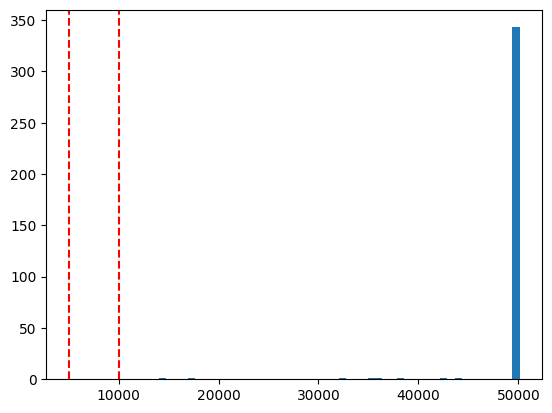

In [ ]:
plt.figure()

plt.hist(IC50["Standard Value"], bins=50)

plt.axvline(x=5000, color='red', linestyle='--', label='valores poitivos')
plt.axvline(x=10000, color='red', linestyle='--', label='valores negativos')

plt.show()

In [ ]:
print(len(IC50))
Activos_IC50_plasmodium= IC50[IC50["Standard Value"]<=5000]
print(len(Activos_IC50_plasmodium))
Inactivos_IC50_plasmodium=IC50[IC50["Standard Value"]>=10000]
print(len(Inactivos_IC50_plasmodium))

351
0
351


In [ ]:
Percent_Effect
#without analyze

,PUBCHEM_RESULT_TAG,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_EXT_DATASOURCE_SMILES,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,PubChem Standard Value,Standard Type,Standard Relation,Standard Value,Standard Units,ROMol,InchiKey
5,1,103189924.0,336326.0,CC1(CCC2=C(O1)N(C3=CC=CC=C3C2=O)C)C,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,0.6631,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba455fe60>,ZMHAAVLGKGXDBY-UHFFFAOYSA-N
6,2,103190102.0,608293.0,CC1(CCC2=C(O1)C3=CC=CC=C3N(C2=O)C)C,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,0.8003,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba455fdf0>,QKYGYGWDLFBXPC-UHFFFAOYSA-N
7,3,103243439.0,453962.0,CC1=CC2=C(C=C1)NC(=O)C3=C(O2)N=CC=C3,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,8.405,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba455fed0>,LIBUCSSGWQGTRG-UHFFFAOYSA-N
8,4,103253958.0,14763452.0,C1CN(CCN1C2=CC=CC=C2)C(=O)NCCN3CCOCC3,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,6.075,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba455ff40>,MAYXLPUSZPNGST-UHFFFAOYSA-N
9,5,103350823.0,10704393.0,CN(C)C1=NC=C(C(=N1)COC)C(=O)OC,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,-1.641,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba455f840>,OHBMNRRXWPKPED-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68974,68970,336856154.0,127024053.0,C1[C@@H]2CN(C[C@@H]2CN1CC3=CC(=CC=C3)C#N)C4=NC...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,4.745,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0970>,QXUBWQVELITOIY-OKZTUQRJSA-N
68975,68971,336856155.0,127024054.0,CC1=NN=C(C=C1)N2CC[C@@H]([C@@H]2CC3=CN=CC=C3)O...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,3.275,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f09e0>,NZIAYXBYYLQTQI-APTPAJQOSA-N
68976,68972,336856156.0,127024055.0,C1CO[C@@H]2CN(C[C@@H]2CN1C3=NC=CC=N3)CC4=COC=C...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,5.037,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0a50>,KQPDTOXIHCTWNQ-CTHHTMFSSA-N
68977,68973,336856157.0,127024056.0,CC1=CSC(=N1)NC(=O)[C@@H]2C[C@H]3[C@@H](O2)CCN3...,Unspecified,NaN,NaN,NaN,NaN,Percent Effect,=,2.058,%,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0ac0>,TXIXAMVGDAEWNX-LFELFHSZSA-N


####IC50

In [ ]:
sinpchembl_plasmodium_IC50 = sinpchembl_plasmodium[sinpchembl_plasmodium["type"]=="IC50"]
sinpchembl_plasmodium_pIC50 = sinpchembl_plasmodium[sinpchembl_plasmodium["type"]=="pIC50"]

In [ ]:
#Data of active ones come from gghe assay CHEMBL3301569
print(sinpchembl_plasmodium_IC50["value"].value_counts())
print(sinpchembl_plasmodium_IC50["units"].value_counts())
print(sinpchembl_plasmodium_IC50["assay_chembl_id"].value_counts())
print(sinpchembl_plasmodium_IC50["assay_description"].value_counts())
print(sinpchembl_plasmodium_IC50["standard_relation"].value_counts())

2.5    400
Name: value, dtype: int64
uM    400
Name: units, dtype: int64
CHEMBL3301569    400
Name: assay_chembl_id, dtype: int64
MMV: KRS recombinant Plasmodium falciparum Lysyl-tRNA-synthetase, assay with yeast tRNA, ATP, and lysine and 3 uM MMV malaria box compound, assay read out with kinase glo as % inhibition.    400
Name: assay_description, dtype: int64
>    400
Name: standard_relation, dtype: int64


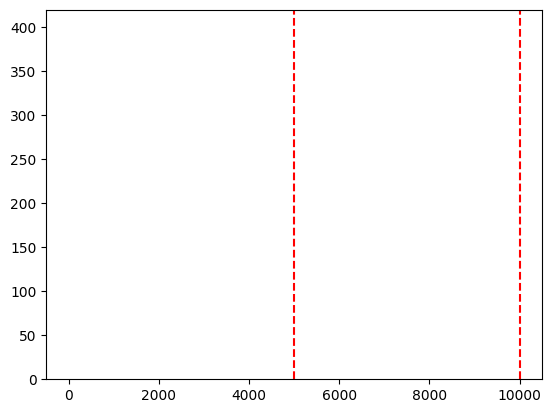

In [ ]:
plt.figure()

plt.hist(sinpchembl_plasmodium_IC50["value"], bins=3)

plt.axvline(x=5000, color='red', linestyle='--', label='valores poitivos')
plt.axvline(x=10000, color='red', linestyle='--', label='valores negativos')

plt.show()

In [ ]:
# Activos_IC50_plasmodium_sinpchembl = Se consideran todos inactivos porque no se vio inhibición a la concentración ensayada
# print(len(Activos_IC50_plasmodium_sinpchembl))
Inactivos_IC50_plasmodium_sinpchembl = sinpchembl_plasmodium_IC50
print(len(Inactivos_IC50_plasmodium_sinpchembl))

400


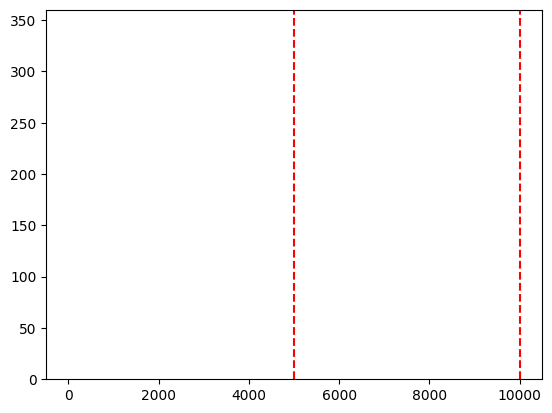

In [ ]:
plt.figure()

plt.hist(sinpchembl_plasmodium_pIC50["value"], bins=5)

plt.axvline(x=5000, color='red', linestyle='--', label='valores poitivos')
plt.axvline(x=10000, color='red', linestyle='--', label='valores negativos')

plt.show()

In [ ]:
Activos_sinpchembl_plasmodium_pIC50=sinpchembl_plasmodium_pIC50[sinpchembl_plasmodium_pIC50["value"]>5.3] #6
print((len(Activos_sinpchembl_plasmodium_pIC50)))
Inactivos_sinpchembl_plasmodium_pIC50=sinpchembl_plasmodium_pIC50[sinpchembl_plasmodium_pIC50["value"]<5] #11
print(len(Inactivos_sinpchembl_plasmodium_pIC50))

0
343


Active /inactive with PLASMODIUM

In [ ]:
activos_plasmodium=pd.concat([Activos_conpchembl_plasmodium,Activos_IC50_plasmodium,Activos_AID_1671156,Activos_sinpchembl_plasmodium_pIC50])
inactivos_plasmodium=pd.concat([Inactivos_conpchembl_plasmodium,Inactivos_IC50_plasmodium,Inactivos_IC50_plasmodium_sinpchembl,Inactivos_sinpchembl_plasmodium_pIC50,Percent_Effect])

In [ ]:
#Activos_IC50_plasmodium_ensayo= IC50[IC50["Standard Value"]<=5000]
#Inactivos_IC50_plasmodium_ensayo=IC50[IC50["Standard Value"]>=10000]

#Final results

In [ ]:
activos_humanos["Activity"]="Active"
inactivos_humanos["Activity"]="Inactive"
activos_humanos["Organismo"]="Human"
inactivos_humanos["Organismo"]="Human"

In [ ]:
activos_plasmodium["Activity"]="Active"
inactivos_plasmodium["Activity"]="Inactive"
activos_plasmodium["Organismo"]="Plasmodium"
inactivos_plasmodium["Organismo"]="Plasmodium"

In [ ]:
inactivos_plasmodium

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,PubChem Standard Value,Standard Type,Standard Relation,Standard Value,Standard Units,Activity,Organismo
413,413.0,NaN,NaN,18530861.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
414,414.0,NaN,NaN,18530862.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
415,415.0,NaN,NaN,18530863.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
69092,69092.0,NaN,NaN,22059677.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
69105,69105.0,NaN,NaN,22060413.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,4.745,%,Inactive,Plasmodium
68975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,3.275,%,Inactive,Plasmodium
68976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,5.037,%,Inactive,Plasmodium
68977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,2.058,%,Inactive,Plasmodium


<Axes: xlabel='count', ylabel='standard_type'>

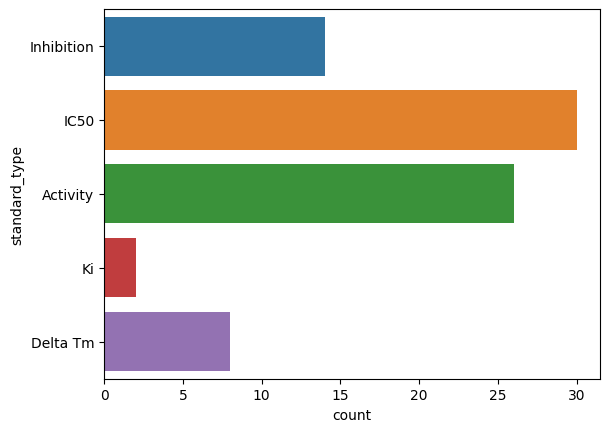

In [ ]:
sns.countplot(data=sinpchembl, y="standard_type")

# Concat data

In [ ]:
Resultados_activos=pd.concat([activos_humanos,activos_plasmodium]) #concat both actives human and plasmodium

<Axes: xlabel='count', ylabel='standard_type'>

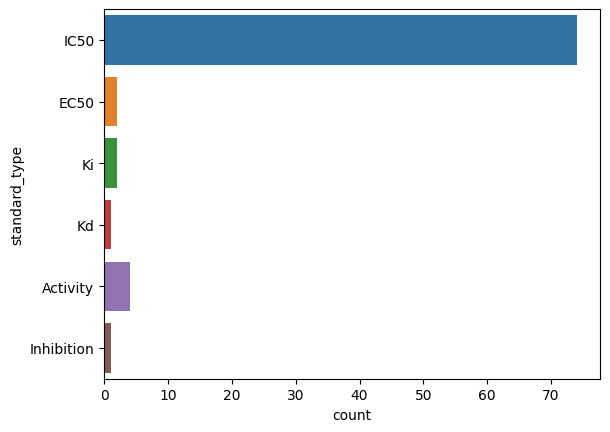

In [ ]:
sns.countplot(data=Resultados_activos, y="standard_type")

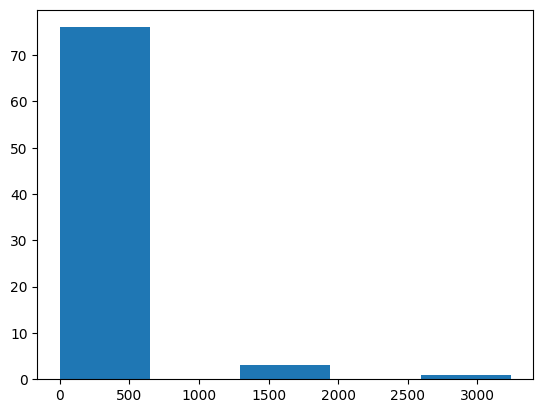

In [ ]:
plt.figure()

plt.hist(Resultados_activos["value"], bins=5)

plt.show()

In [ ]:
Resultados_activos["type"].unique()

array(['IC50', 'EC50', 'Ki', 'pKd', 'Activity', 'INH', 'pIC50', nan],
      dtype=object)

In [ ]:
Resultados_activos_IC50 = Resultados_activos[Resultados_activos["type"] == 'IC50']
print(Resultados_activos_IC50["units"].unique())
Resultados_activos_IC50_uM = Resultados_activos_IC50[Resultados_activos_IC50["units"] == 'uM']
Resultados_activos_IC50_nM = Resultados_activos_IC50[Resultados_activos_IC50["units"] == 'nM']
Resultados_activos_EC50 = Resultados_activos[Resultados_activos["type"] == 'EC50']
print(Resultados_activos_EC50["units"].unique())
Resultados_activos_Ki = Resultados_activos[Resultados_activos["type"] == 'Ki']
print(Resultados_activos_Ki["units"].unique())
Resultados_activos_pKd = Resultados_activos[Resultados_activos["type"] == 'pKd']
print(Resultados_activos_pKd["units"].unique())
Resultados_activos_Activity = Resultados_activos[Resultados_activos["type"] == 'Activity']
print(Resultados_activos_Activity["units"].unique())
Resultados_activos_pIC50 = Resultados_activos[Resultados_activos["type"] == 'pIC50']
print(Resultados_activos_pIC50["units"].unique())
Resultados_activos_nan = Resultados_activos[Resultados_activos["type"] == 'nan']
print(Resultados_activos_nan["units"].unique())

['uM' 'nM']
['nM']
['uM']
[nan]
[nan]
[nan]
[]


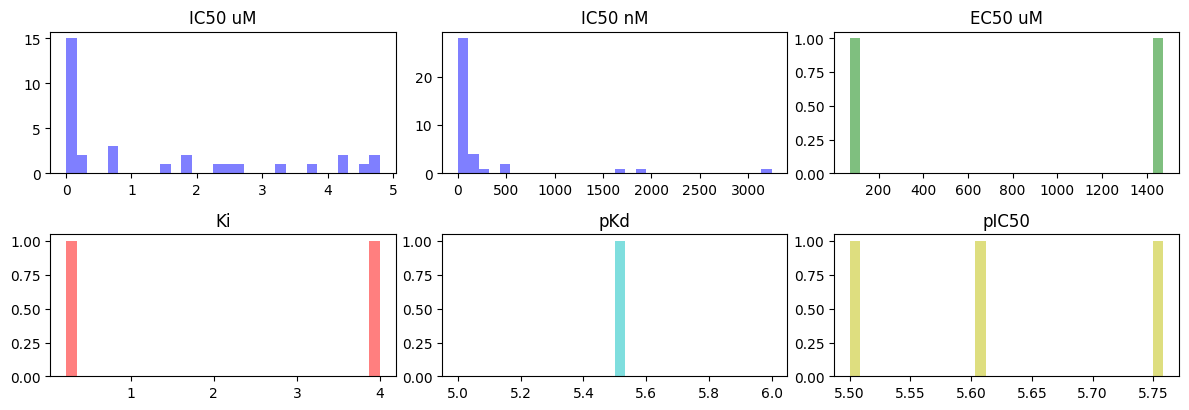

In [ ]:
#Type of assa distribution

plt.figure(figsize=(12, 6))

plt.subplot(3, 3, 1)
plt.hist(Resultados_activos_IC50_uM["value"], bins=30, color='b', alpha=0.5, label='IC50 uM')
plt.title('IC50 uM')

plt.subplot(3, 3, 2)
plt.hist(Resultados_activos_IC50_nM["value"], bins=30, color='b', alpha=0.5, label='IC50 nM')
plt.title('IC50 nM')

plt.subplot(3, 3, 3)
plt.hist(Resultados_activos_EC50["value"], bins=30, color='g', alpha=0.5, label='EC50 uM')
plt.title('EC50 uM')

plt.subplot(3, 3, 4)
plt.hist(Resultados_activos_Ki["value"], bins=30, color='r', alpha=0.5, label='Ki')
plt.title('Ki')

plt.subplot(3, 3, 5)
plt.hist(Resultados_activos_pKd["value"], bins=30, color='c', alpha=0.5, label='pKd')
plt.title('pKd')


# plt.hist(Resultados_activos_Activity["value"], bins=30, color='m', alpha=0.5, label='Activity') # No se puedel clasificar, solo dicen acitvo o inactivo (son 4)

plt.subplot(3, 3, 6)
plt.hist(Resultados_activos_pIC50["value"], bins=30, color='y', alpha=0.5, label='pIC50')
plt.title('pIC50')


plt.tight_layout()
plt.show()

In [ ]:
print(len(Resultados_activos))

Resultados_activos_sinpchembl=Resultados_activos[Resultados_activos.pchembl_value.isnull()]
print(len(Resultados_activos_sinpchembl))
Resultados_activos_conpchembl=Resultados_activos[Resultados_activos.pchembl_value.notnull()]
print(len(Resultados_activos_conpchembl))

87
9
78


<Axes: xlabel='count', ylabel='standard_type'>

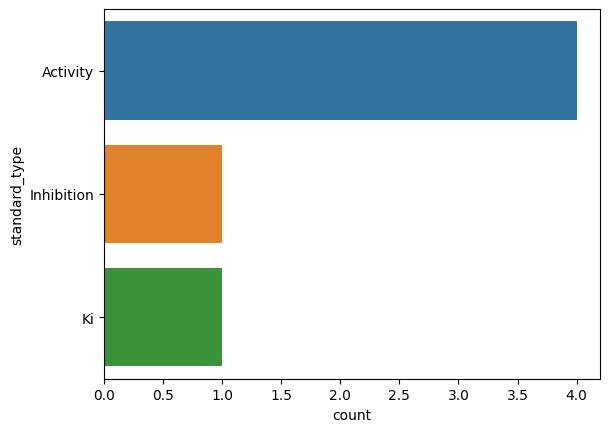

In [ ]:
sns.countplot(data=Resultados_activos_sinpchembl, y="standard_type")

In [ ]:
Resultados_activos_sinpchembl["standard_type"].value_counts()

Activity      4
Inhibition    1
Ki            1
Name: standard_type, dtype: int64

(array([21., 13., 23., 18.,  3.]),
 array([5.32, 6.1 , 6.88, 7.66, 8.44, 9.22]),
 <BarContainer object of 5 artists>)

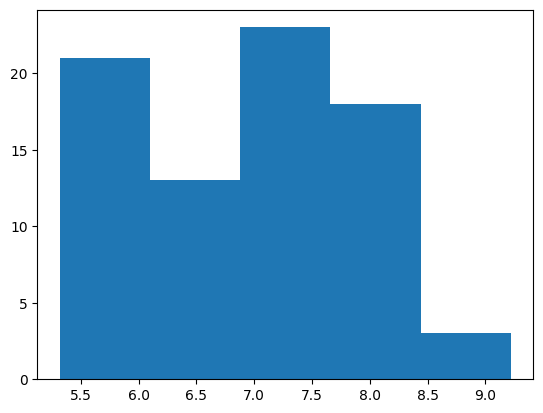

In [ ]:
plt.hist(Resultados_activos["pchembl_value"], bins=5)

In [ ]:
Resultados_activos_IC50["units"].value_counts()
print(len(Resultados_activos_IC50["pchembl_value"]))
print(len(Resultados_activos_IC50))

71
71


In [ ]:
inactivos_plasmodium

,Unnamed: 0,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,...,PUBCHEM_ACTIVITY_SCORE,PUBCHEM_ACTIVITY_URL,PUBCHEM_ASSAYDATA_COMMENT,PubChem Standard Value,Standard Type,Standard Relation,Standard Value,Standard Units,Activity,Organismo
413,413.0,NaN,NaN,18530861.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
414,414.0,NaN,NaN,18530862.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
415,415.0,NaN,NaN,18530863.0,[],CHEMBL4195366,Inhibition of Plasmodium falciparum KRS expres...,B,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
69092,69092.0,NaN,NaN,22059677.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
69105,69105.0,NaN,NaN,22060413.0,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4649943,"Pf-KRS-1 (Lysyl-RNA Synthetase-1, KRS-1, cytos...",F,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inactive,Plasmodium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,4.745,%,Inactive,Plasmodium
68975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,3.275,%,Inactive,Plasmodium
68976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,5.037,%,Inactive,Plasmodium
68977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Percent Effect,=,2.058,%,Inactive,Plasmodium


In [ ]:
#concatenar estos y que tengan solo las columnas smiles, activity, organismo
columnas = ['canonical_smiles', 'ROMol', 'InchiKey', 'Activity', 'Organismo','assay_chembl_id','type'] #interesting columns
df1=activos_humanos[columnas] #human actives
df2=inactivos_humanos[columnas] #human inactives
df3=activos_plasmodium[columnas] #plasmodium actives
df4=inactivos_plasmodium[columnas] #plasmodium inactives

Resultados=pd.concat([df1,df2,df3,df4])

In [ ]:
inactivos_plasmodium['InchiKey']

413      WOMKDMUZNBFXKG-XDTLVQLUSA-N
414      WOMKDMUZNBFXKG-WQAKAFBOSA-N
415      WOMKDMUZNBFXKG-ICCXJUOJSA-N
69092    LJJZOBHOAMJDPP-UHFFFAOYSA-N
69105    QLVPAQIOBRANAC-UHFFFAOYSA-N
                    ...             
68974    QXUBWQVELITOIY-OKZTUQRJSA-N
68975    NZIAYXBYYLQTQI-APTPAJQOSA-N
68976    KQPDTOXIHCTWNQ-CTHHTMFSSA-N
68977    TXIXAMVGDAEWNX-LFELFHSZSA-N
68978                            NaN
Name: InchiKey, Length: 69725, dtype: object

In [ ]:
Resultados.Activity.value_counts()

Inactive    69759
Active         87
Name: Activity, dtype: int64

In [ ]:
#Resultados = Resultados.dropna()
Resultados = Resultados.drop_duplicates(subset=['InchiKey'])
Resultados = Resultados.reset_index()

In [ ]:
Resultados.Activity.value_counts()

Inactive    69044
Active         79
Name: Activity, dtype: int64

In [ ]:
Activos_Resultados=Resultados[Resultados['Activity']=="Active"]
Inactivos_Resultados=Resultados[Resultados['Activity']=="Inactive"]

In [ ]:
print(Resultados.Organismo.value_counts())
print(Activos_Resultados.Organismo.value_counts())
print(Inactivos_Resultados.Organismo.value_counts())

Plasmodium    69019
Human           104
Name: Organismo, dtype: int64
Human         74
Plasmodium     5
Name: Organismo, dtype: int64
Plasmodium    69014
Human            30
Name: Organismo, dtype: int64


<Axes: xlabel='Activity', ylabel='Count'>

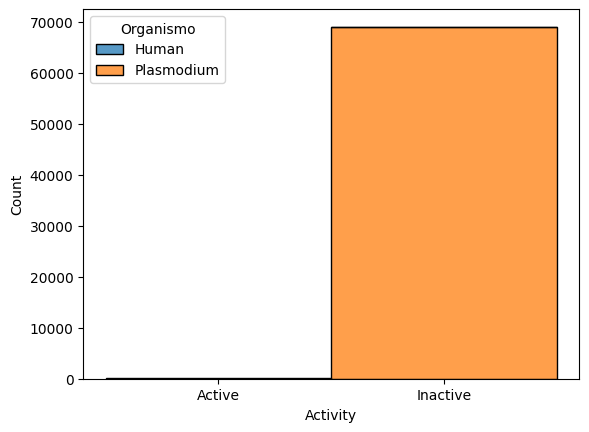

In [ ]:
import seaborn as sns

#create histogram to visualize distribution of points by team
sns.histplot(data=Resultados, x='Activity', hue='Organismo', multiple = "stack")

In [ ]:
Resultados.to_csv("Resultados_compuestos_lys.csv")
Activos_Resultados.to_csv("Resultados_compuestos_activos_lys.csv")
Inactivos_Resultados.to_csv("Resultados_compuestos_inactivos_lys.csv")

# Fingerprints:
*  Verify results distrbution
*  Verify if structrures are similar (fingerprints, tanimoto)

In [ ]:
from rdkit.Chem.Fingerprints import FingerprintMols
import warnings
import numpy as np
from rdkit import Chem, DataStructs
from scipy.cluster.hierarchy import dendrogram, linkage, is_valid_linkage, cut_tree

In [ ]:
Activos_Resultados = Activos_Resultados.reset_index(drop=True)
Inactivos_Resultados = Inactivos_Resultados.reset_index(drop=True)

In [ ]:
Activos_Resultados["ID"] = range(len(Activos_Resultados))
Inactivos_Resultados["ID"] = range(len(Inactivos_Resultados))

In [ ]:
Datos = Activos_Resultados

In [ ]:
fps = [FingerprintMols.FingerprintMol(mol) for mol in Datos['ROMol']]
# Configurar el manejo de advertencias
warnings.filterwarnings('ignore')

# Obtener el tamaño de la tabla
size = len(Datos)

# Crear un arreglo vacío para almacenar la matriz de similitud
hmap = np.empty(shape=(size, size))

# Crear un DataFrame vacío
table = pd.DataFrame()

# Iterar sobre las filas de la tabla
for i in range(len(Datos)):
    # Iterar sobre las columnas de la tabla
    for j in range(len(Datos)):
        # Calcular la similitud de huellas moleculares entre fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        # Almacenar la similitud en la matriz hmap
        hmap[i, j] = similarity
        # Agregar la similitud al DataFrame 'table' con los índices correspondientes
        table.loc[Datos['ID'][i], Datos['ID'][j]] = similarity

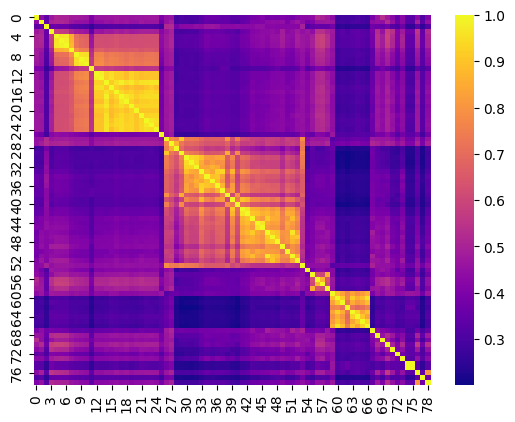

In [ ]:
#Generar el gráfico de tipo heatmap de la tabla de datos
heatmap = sns.heatmap(data=table,cmap='plasma')

# Mostrar el gráfico
plt.show()

In [ ]:
# Realizar la clusterización utilizando el método single de la matriz de similitud 'hmap'
linked = linkage(hmap, 'complete')

# Verifica la validez de la matriz
print(is_valid_linkage(linked))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla
labelList = [Datos['ID'][i] for i in range(len(Datos))]

True


In [ ]:
def plot_dendrogram(model, **kwargs):
    # Crea una matriz de clustering y luego traza el dendrograma

    # Crea los conteos de muestras bajo cada nodo
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # Nodo hoja
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Trama el dendrograma correspondiente
    dendrogram(linkage_matrix, **kwargs)

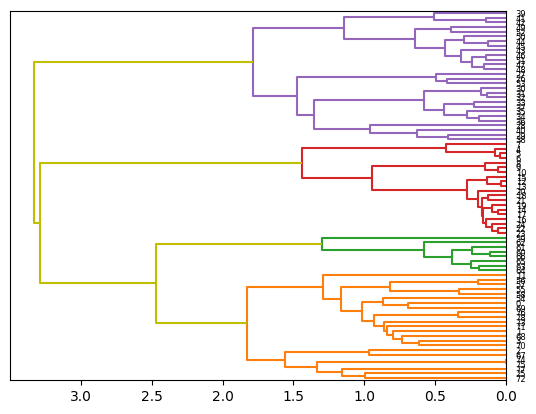

In [ ]:
o = dendrogram(linked, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

In [ ]:
# Esto nos dará los clústeres en orden según el último dendrograma
new_data = list(reversed(o['ivl']))

# Creamos una nueva tabla con el orden del agrupamiento jerárquico (HCL)
hmap_2 = np.empty(shape=(size, size))
for index, i in enumerate(new_data):
    for jndex, j in enumerate(new_data):
        hmap_2[index, jndex] = table.loc[i].at[j]

[]

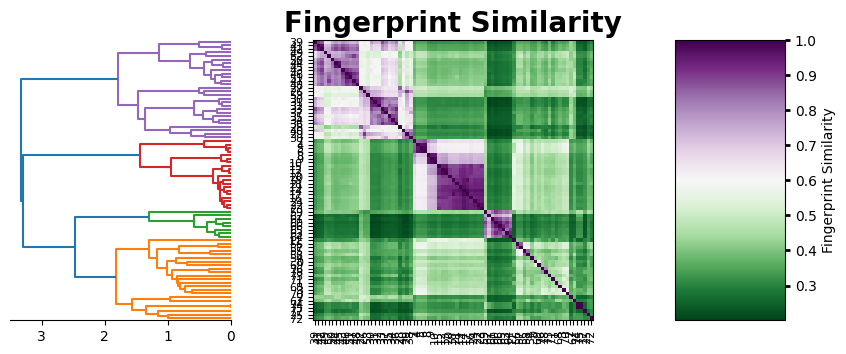

In [ ]:
# Crear una figura con tamaño de 10x8 pulgadas
figure = plt.figure(figsize=(10,8))

# Crear una rejilla de subtramas con 2 filas y 7 columnas
gs1 = gridspec.GridSpec(2, 7)
gs1.update(wspace=0.01)

# Subtrama para el dendrograma
ax1 = plt.subplot(gs1[0:-1, :2])
dendrogram(linked, orientation='left', distance_sort='descending', show_leaf_counts=True, no_labels=True)
ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Subtrama para la matriz de similitud
ax2 = plt.subplot(gs1[0:-1, 2:6])
f = ax2.imshow(hmap_2, cmap='PRGn_r', interpolation='nearest')
ax2.set_title('Fingerprint Similarity', fontsize=20, weight='bold')
ax2.set_xticks(range(len(new_data)))
ax2.set_yticks(range(len(new_data)))
ax2.set_xticklabels(new_data, rotation=90, size=8)
ax2.set_yticklabels(new_data, size=8)

# Subtrama para la barra de color
ax3 = plt.subplot(gs1[0:-1, 6:7])
m = plt.colorbar(f, cax=ax3, shrink=0.75, orientation='vertical', spacing='uniform', pad=0.01)
m.set_label('Fingerprint Similarity')

# Configurar los parámetros de las etiquetas de los ejes
plt.tick_params('both', width=2)

# Mostrar el gráfico
plt.plot()

In [ ]:
# Indicar la cantidad de clusters:
n = 4

# Obtener los clusters utilizando cut_tree con un número específico de clusters
clusters = cut_tree(linked, n)

# Agregar el número de cluster a la tabla
Datos['Cluster_fingerprints'] = clusters.flatten()
Datos

,index,canonical_smiles,ROMol,InchiKey,Activity,Organismo,assay_chembl_id,type,ID,Cluster_fingerprints
0,0,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f1b0>,QQWUGDVOUVUTOY-UHFFFAOYSA-N,Active,Human,CHEMBL1006347,IC50,0,0
1,1,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1Cc2cnc(N)...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0eea0>,ZWVLMQTXUWMUII-UHFFFAOYSA-N,Active,Human,CHEMBL974011,EC50,1,0
2,4,CN(C)c1ccc(-c2cc3ncccc3c(NCCCCN)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0ed50>,SBGMPUIVPOGTGN-UHFFFAOYSA-N,Active,Human,CHEMBL1025770,IC50,2,0
3,5,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0e2d0>,HKSZLNNOFSGOKW-FYTWVXJKSA-N,Active,Human,CHEMBL981176,IC50,3,0
4,6,COc1cc(Nc2nc(N[C@H]3CCCC[C@H]3N)n3nc(-c4ccccc4...,<rdkit.Chem.rdchem.Mol object at 0x7fdbf0d5cb30>,VLHKHLQNVJKAHG-UXHICEINSA-N,Active,Human,CHEMBL981176,IC50,4,1
...,...,...,...,...,...,...,...,...,...,...
74,403,C[C@@H]1CCC[C@H](C[C@H]2Cc3cc(O)cc(O)c3C(=O)O2)O1,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32500>,WOMKDMUZNBFXKG-OASPWFOLSA-N,Active,Plasmodium,CHEMBL4195366,IC50,74,0
75,410,C[C@H]1CCC[C@H](C[C@@H]2Cc3cc(O)cc(O)c3C(=O)O2)O1,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32810>,WOMKDMUZNBFXKG-BIMULSAOSA-N,Active,Plasmodium,CHEMBL4195366,IC50,75,0
76,69041,Cc1cccc(NC2CCc3c2[nH]c(=O)n(C2CCCCC2)c3=O)c1C,<rdkit.Chem.rdchem.Mol object at 0x7fdba63ef920>,VKLJGFUGCIOKKO-UHFFFAOYSA-N,Active,Plasmodium,CHEMBL4649943,pIC50,76,0
77,69127,Nc1ncc2c(n1)CN(C1CCCC1)C2=O,<rdkit.Chem.rdchem.Mol object at 0x7fdba63f5f50>,RUUUZPDEYNEEEZ-UHFFFAOYSA-N,Active,Plasmodium,CHEMBL4649943,pIC50,77,0


In [ ]:
Datos['Cluster_fingerprints'].unique()

array([0, 1, 2, 3])

In [ ]:
Chem.Draw.MolsToGridImage(Datos.ROMol,molsPerRow=7)

In [ ]:
Datos_cluster_0 = Datos[Datos['Cluster_fingerprints'] == 0]
Datos_cluster_1 = Datos[Datos['Cluster_fingerprints'] == 1]
Datos_cluster_2 = Datos[Datos['Cluster_fingerprints'] == 2]
Datos_cluster_3 = Datos[Datos['Cluster_fingerprints'] == 3]

###Cluster 0 image structures

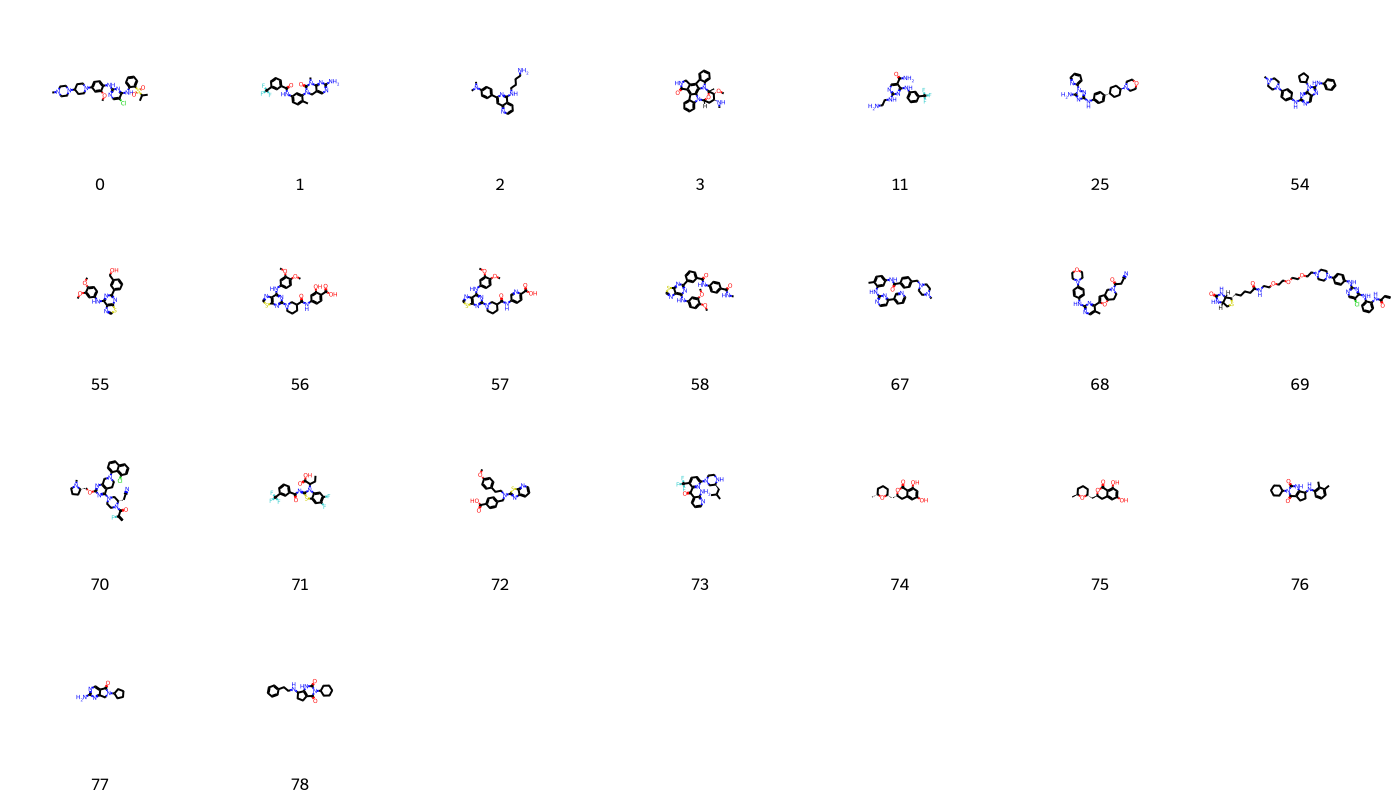

In [ ]:
IDs = list(Datos_cluster_0.ID.astype(str))
Chem.Draw.MolsToGridImage(Datos_cluster_0.ROMol,molsPerRow=7,legends=IDs)

###Cluster 1 image structures

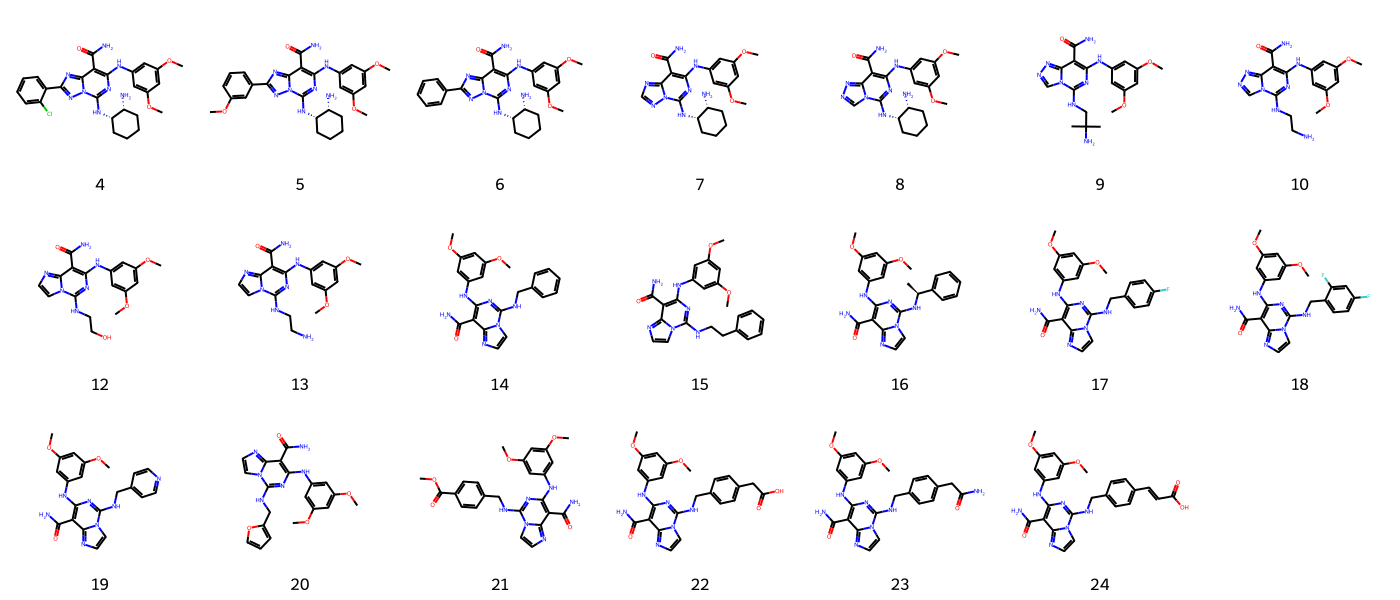

In [ ]:
IDs = list(Datos_cluster_1.ID.astype(str))
Chem.Draw.MolsToGridImage(Datos_cluster_1.ROMol,molsPerRow=7,legends=IDs)

###Cluster 2 image structures

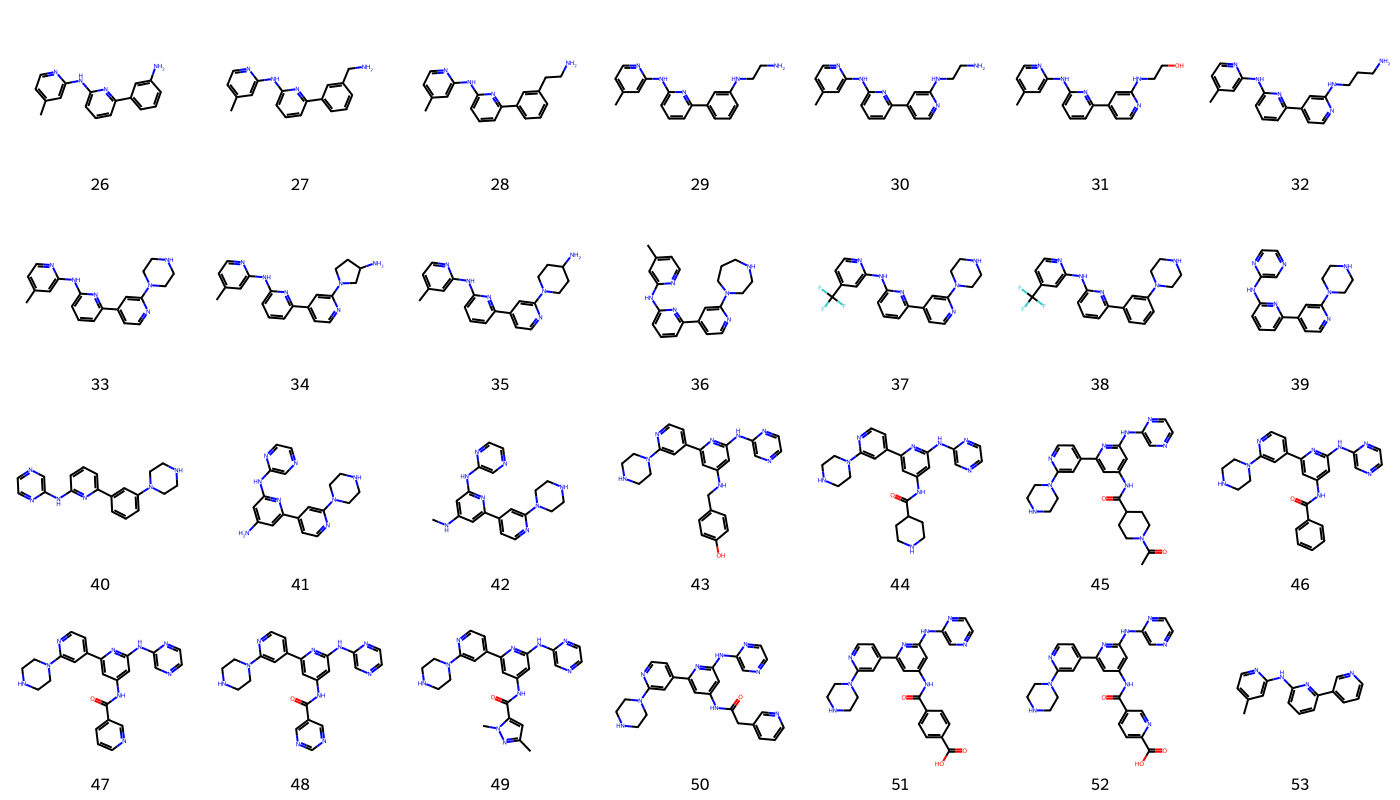

In [ ]:
IDs = list(Datos_cluster_2.ID.astype(str))
Chem.Draw.MolsToGridImage(Datos_cluster_2.ROMol,molsPerRow=7,legends=IDs)

###Cluster 3 image structures

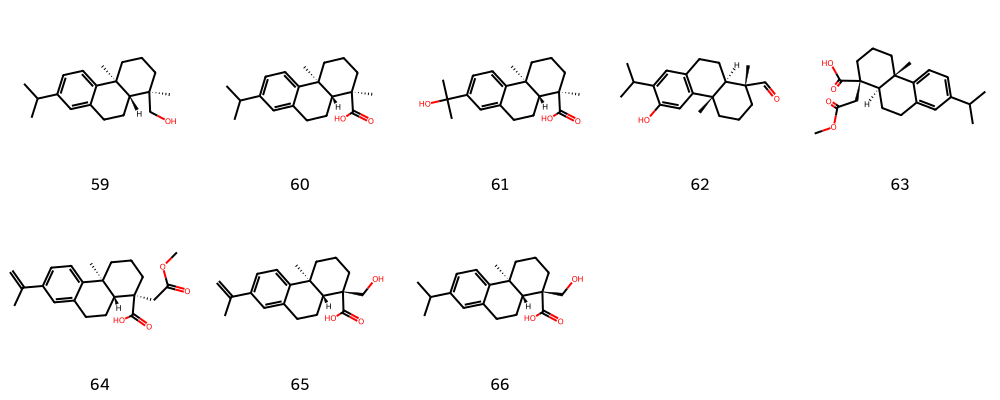

In [ ]:
IDs = list(Datos_cluster_3.ID.astype(str))
Chem.Draw.MolsToGridImage(Datos_cluster_3.ROMol,molsPerRow=5,legends=IDs)

#PCA

similarity analysis (active compounds)

In [ ]:
# Importar las funciones de 'sklearn'
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

In [ ]:
Resultados.columns #Resultados = Activos_Resultados

Index(['index', 'canonical_smiles', 'ROMol', 'InchiKey', 'Activity',
       'Organismo', 'assay_chembl_id', 'type'],
      dtype='object')

In [ ]:
# Check if a  SMILES string is valid.
SMILES = []
for i in range(len(Activos_Resultados['canonical_smiles'])):
  try:
    cs = Chem.CanonSmiles(Activos_Resultados['canonical_smiles'].iloc[i])
    SMILES.append(cs)

  except:
    print('Invalid SMILES:',Activos_Resultados['canonical_smiles'].iloc[i],i)

In [ ]:
#DESCRIPTORS

# molecules from smiles
ms = [Chem.MolFromSmiles(smile) for smile in SMILES]
# number of atoms per molecule
numb = [mol.GetNumAtoms() for mol in ms]
# different atoms:
C = [] # carbon
O = [] # oxigen
N = [] # nitrogen
Cl=[]  # Chlorine
F=[]   #fluroine
Br=[]  #bromine
I=[]   #iodine

nh2_pattern = Chem.MolFromSmarts("[NH2]")
nh2_counts = [len(mol.GetSubstructMatches(nh2_pattern)) for mol in ms]

ring5_counts = [] #5 carbon ring
ring6_counts=[] #6 cabron ring




for mol in ms:
  c = 0
  o = 0
  n = 0
  cl=0
  f=0
  br=0
  i=0
  nh2_count = 0
  ring_info = mol.GetRingInfo()# saturated ring
  ring5_count = sum(1 for ring in ring_info.AtomRings() if len(ring) == 5)  # Counting 5 carbon rings
  ring5_counts.append(ring5_count)
  ring6= sum(1 for ring in ring_info.AtomRings()if len(ring) == 6)  # Counting 6 carbon rings
  ring6_counts.append(ring6)
  for atom in mol.GetAtoms():
    if atom.GetAtomicNum() == 6:
      c += 1
    if atom.GetAtomicNum() == 7:
      n += 1
    if atom.GetAtomicNum() == 8:
      o += 1
    if atom.GetAtomicNum() == 9:
      f += 1
    if atom.GetAtomicNum() == 17:
      cl += 1
    if atom.GetAtomicNum() == 35:
      br += 1
    if atom.GetAtomicNum() == 53:
      i += 1

  C.append(c)
  O.append(o)
  N.append(n)
  Cl.append(cl)
  F.append(f)
  Br.append(br)
  I.append(i)

# molecular weight
MolWeight = [Descriptors.ExactMolWt(mol) for mol in ms]
# rings
Rings = [Descriptors.RingCount(mol) for mol in ms]
# Total polar surface area
TPSA = [Descriptors.TPSA(mol) for mol in ms]
# Density Morgan FP
FpDM1 = [Descriptors.FpDensityMorgan1(mol) for mol in ms]
# rotatable bonds
RotBonds = [Descriptors.NumRotatableBonds(mol) for mol in ms]
# Obtener la carga formal de la molécula
formal_charge =[Chem.rdmolops.GetFormalCharge(mol) for mol in ms]
# Calcular el logP (coeficiente de partición octanol-agua) de la molécula
logp =[Descriptors.MolLogP(mol) for mol in ms]

In [ ]:
descriptors = pd.DataFrame(list(zip(numb, C, O, N,F,Br,I,Cl, nh2_counts,ring5_counts,ring6_counts,MolWeight, Rings, TPSA, FpDM1, RotBonds,logp,formal_charge)))
#all descriptores zipped in this dataframe


Activity= Activos_Resultados["Activity"].tolist()

In [ ]:
# Molecular descriptors retrieval from the table
# descriptors = Results.loc[:, ['MW', 'TPSA', 'nRotB', 'HBD', 'HBA', 'logP']].values

# Normalize descriptors using StandardScaler
descriptors_std = StandardScaler().fit_transform(descriptors)

# Apply PCA to normalized descriptors
pca = PCA()
descriptors_2d = pca.fit_transform(descriptors_std)

# Data formatting
# Create a DataFrame with PCA coordinates
descriptors_pca = pd.DataFrame(descriptors_2d)

# Set the DataFrame index as the index of the CHEMBL674637 table
descriptors_pca.index = Activos_Resultados.index

# Label the DataFrame columns as PC1, PC2, PC3, etc.
descriptors_pca.columns = ['PC{}'.format(i+1) for i in descriptors_pca.columns]


# Display the DataFrame with PCA coordinates
descriptors_pca

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18
0,4.549939,-2.311358,1.590904,1.033922,-2.580307,1.376360,1.047960,0.180779,0.713653,-0.226543,0.108244,0.311350,-0.088545,0.092726,0.001458,-7.675690e-17,-1.634789e-18,0.0
1,-0.188224,-0.586201,0.535136,2.828674,0.752230,-1.224911,0.559629,-1.239325,0.034739,-0.316961,0.002984,0.107539,-0.007336,-0.056501,-0.001629,-2.961627e-17,-1.149882e-18,-0.0
2,-1.801382,-0.225041,-0.603126,0.357981,-0.744894,0.971228,-0.851381,-0.206452,-0.718785,0.157988,-0.111772,0.095323,0.005809,0.017764,-0.003060,6.307527e-17,1.188605e-18,-0.0
3,2.435312,-1.424091,1.917821,-2.268924,4.153574,0.981313,1.540326,-0.629255,0.244030,0.694375,-0.078523,0.042199,0.344084,0.031954,-0.005286,-2.121051e-17,-2.491516e-18,-0.0
4,3.818502,1.054330,0.903454,1.143948,-1.685479,2.538468,1.658943,-1.072474,1.231749,-0.407232,-0.170772,-0.195188,0.126829,-0.053230,0.003320,5.881344e-17,6.825680e-19,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,-3.333026,0.254021,1.468293,-1.113471,-0.922680,-1.318502,0.716472,0.347133,1.107200,0.413232,-0.116679,0.101667,-0.032263,-0.028836,0.005899,9.713967e-18,2.390774e-18,-0.0
75,-3.333026,0.254021,1.468293,-1.113471,-0.922680,-1.318502,0.716472,0.347133,1.107200,0.413232,-0.116679,0.101667,-0.032263,-0.028836,0.005899,9.713967e-18,2.390774e-18,-0.0
76,-1.409213,-0.812771,0.895606,-0.901840,0.796880,0.447815,0.037591,0.283473,0.258742,-0.036419,0.259820,-0.130410,-0.097793,-0.003243,0.011181,-7.981793e-18,1.677553e-19,0.0
77,-4.755452,2.991984,0.129789,-0.973720,1.542304,1.610445,1.817898,1.140953,-0.109444,-0.283353,0.092560,-0.106764,-0.098277,0.037389,-0.006948,8.033702e-17,2.613497e-18,0.0


In [ ]:
# Variance for each principal component
explained_variance_ratio = pca.explained_variance_ratio_
print(explained_variance_ratio)

explained_variance_cumulative = sum(explained_variance_ratio)
print(explained_variance_cumulative)

[4.17928400e-01 1.87906417e-01 1.33964589e-01 7.41195061e-02
 5.65086646e-02 5.02716008e-02 3.60710786e-02 2.39893867e-02
 1.22903457e-02 4.11592802e-03 1.56043072e-03 5.60216541e-04
 5.11787049e-04 1.97688484e-04 3.96046966e-06 3.49913143e-34
 1.24705065e-36 0.00000000e+00]
1.0


<Figure size 800x600 with 0 Axes>

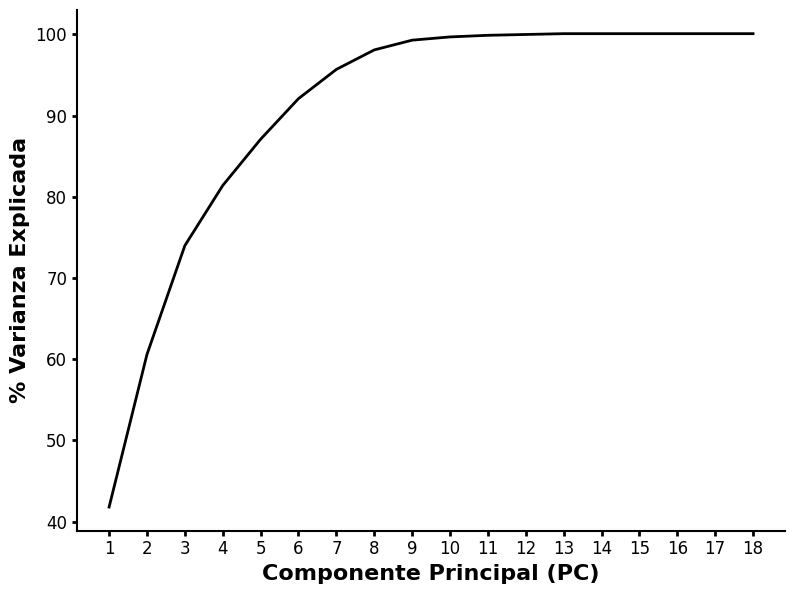

In [ ]:
#Graphic configuration

# Configuración de las propiedades de las gráficas
plt.rcParams['axes.linewidth'] = 1.5

# Creación de la figura y los ejes de la gráfica
plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))

# Cálculo de la varianza acumulada y trazado de la curva de varianza explicada
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.plot([i+1 for i in range(len(var))],var,'k-',linewidth=2)

# Configuración de los ticks y etiquetas de los ejes
plt.xticks([i+1 for i in range(len(var))])
plt.ylabel('% Varianza Explicada',fontsize=16,fontweight='bold')
plt.xlabel('Componente Principal (PC)',fontsize=16,fontweight='bold')

# Configuración de los bordes de la gráfica
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajuste del diseño de la gráfica
plt.tight_layout()
plt.tick_params('both',width=2,labelsize=12)


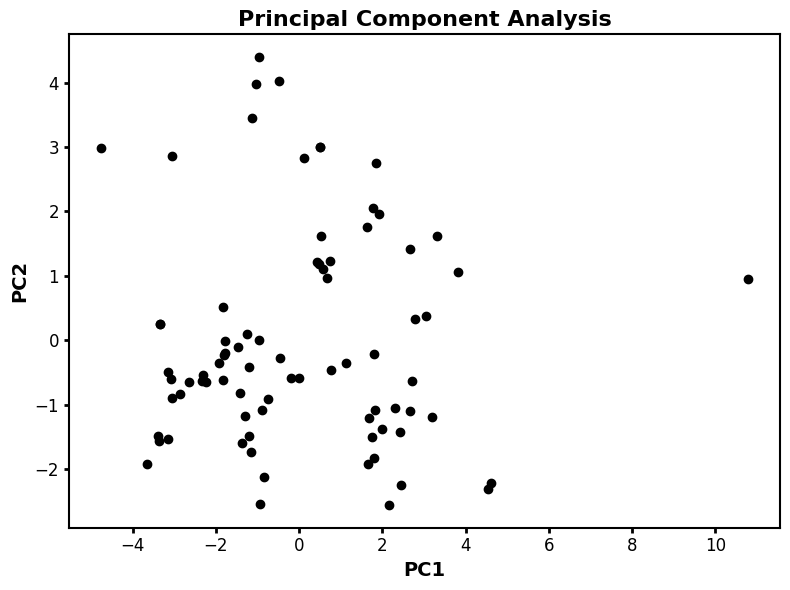

In [ ]:
# Creating figures

fig = plt.figure(figsize=(8,6))
# Agregamos un subplot a la figura
ax = fig.add_subplot(111)

# Graficamos los puntos en el espacio de las dos primeras componentes principales
ax.plot(descriptors_pca['PC1'], descriptors_pca['PC2'], 'o', color='k')

# Configuramos el título del gráfico
ax.set_title('Principal Component Analysis', fontsize=16, fontweight='bold', family='sans-serif')
# Configuramos la etiqueta del eje x
ax.set_xlabel('PC1', fontsize=14, fontweight='bold')
# Configuramos la etiqueta del eje y
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')

# Configuramos los parámetros de los ticks y labels
plt.tick_params('both', width=2, labelsize=12)

# Ajustamos el espaciado del gráfico
plt.tight_layout()
# Mostramos el gráfico
plt.show()

In [ ]:

#We calculate the scale to normalize the principal components.
scale1 = 1.0 / (max(descriptors_pca['PC1']) - min(descriptors_pca['PC1']))
scale2 = 1.0 / (max(descriptors_pca['PC2']) - min(descriptors_pca['PC2']))

#normalize principal components in new columns
descriptors_pca['PC1_normalized'] = [i * scale1 for i in descriptors_pca['PC1']]
descriptors_pca['PC2_normalized'] = [i * scale2 for i in descriptors_pca['PC2']]

#printing first 10 rows
descriptors_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC1_normalized,PC2_normalized
0,4.549939,-2.311358,1.590904,1.033922,-2.580307,1.376360,1.047960,0.180779,0.713653,-0.226543,0.108244,0.311350,-0.088545,0.092726,0.001458,-7.675690e-17,-1.634789e-18,0.0,0.292884,-0.331840
1,-0.188224,-0.586201,0.535136,2.828674,0.752230,-1.224911,0.559629,-1.239325,0.034739,-0.316961,0.002984,0.107539,-0.007336,-0.056501,-0.001629,-2.961627e-17,-1.149882e-18,-0.0,-0.012116,-0.084160
2,-1.801382,-0.225041,-0.603126,0.357981,-0.744894,0.971228,-0.851381,-0.206452,-0.718785,0.157988,-0.111772,0.095323,0.005809,0.017764,-0.003060,6.307527e-17,1.188605e-18,-0.0,-0.115957,-0.032309
3,2.435312,-1.424091,1.917821,-2.268924,4.153574,0.981313,1.540326,-0.629255,0.244030,0.694375,-0.078523,0.042199,0.344084,0.031954,-0.005286,-2.121051e-17,-2.491516e-18,-0.0,0.156763,-0.204456
4,3.818502,1.054330,0.903454,1.143948,-1.685479,2.538468,1.658943,-1.072474,1.231749,-0.407232,-0.170772,-0.195188,0.126829,-0.053230,0.003320,5.881344e-17,6.825680e-19,0.0,0.245800,0.151369
5,3.319941,1.619297,-0.415873,-0.082533,0.263169,-0.233102,-0.634984,-1.617565,0.299895,0.264283,0.091222,0.033799,-0.062009,0.026432,0.010143,5.573966e-16,-5.161606e-18,0.0,0.213708,0.232481
6,2.659649,1.418177,-0.588880,-0.029998,0.395228,0.072447,-0.258770,-1.704964,-0.004692,0.135973,-0.023749,-0.057051,-0.014984,0.054942,0.005190,-4.367315e-17,3.472046e-17,0.0,0.171204,0.203607
7,0.500188,3.001545,-0.992576,-0.076213,0.080823,0.016906,0.513787,-0.695660,0.017065,-0.011078,-0.005471,0.027323,-0.015739,0.063760,0.009760,-7.861294e-17,-4.160535e-18,-0.0,0.032198,0.430929
8,0.500188,3.001545,-0.992576,-0.076213,0.080823,0.016906,0.513787,-0.695660,0.017065,-0.011078,-0.005471,0.027323,-0.015739,0.063760,0.009760,-7.861294e-17,-4.160535e-18,0.0,0.032198,0.430929
9,-0.485656,4.027430,-0.916950,0.104439,-0.294612,0.196919,0.173537,0.071035,-0.185450,-0.202401,0.268359,0.065598,-0.030940,0.018421,0.005173,-1.328646e-17,-1.067171e-20,0.0,-0.031262,0.578215


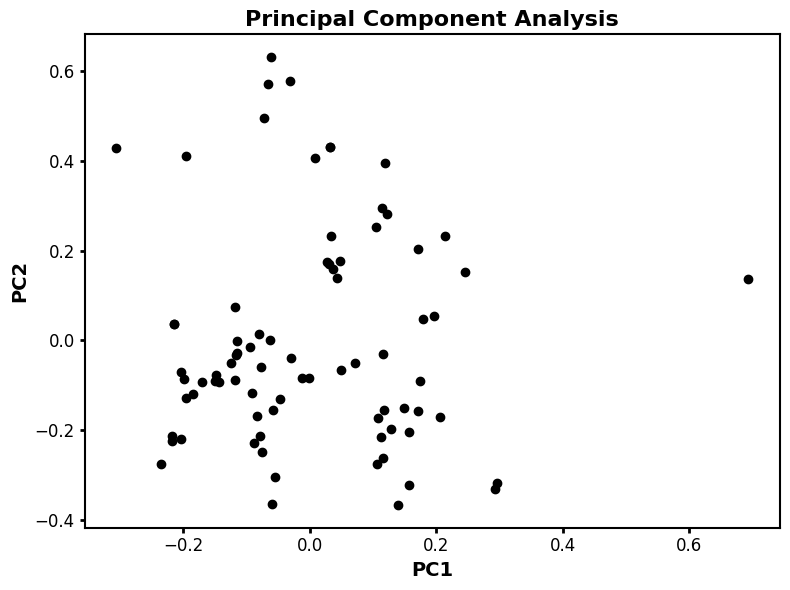

In [ ]:
# Creating figure
fig = plt.figure(figsize=(8, 6))

# Agregar un único subplot en la figura
ax = fig.add_subplot(111)

# Graficar las componentes principales normalizadas
ax.plot(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'], 'o', color='k')

# Establecer el título del gráfico
ax.set_title('Principal Component Analysis', fontsize=16, fontweight='bold', family='sans-serif')

# Etiquetar el eje x
ax.set_xlabel('PC1', fontsize=14, fontweight='bold')

# Etiquetar el eje y
ax.set_ylabel('PC2', fontsize=14, fontweight='bold')

# Configurar los parámetros de las marcas en los ejes
plt.tick_params('both', width=2, labelsize=12)

# Ajustar el diseño del gráfico
plt.tight_layout()

# Mostrar el gráfico
plt.show()

In [ ]:
# Cluster number to evaluate
range_K_clusters = [2, 3, 4, 5, 6, 7]

Para n_clusters = 2 El coeficiente de silueta promedio es: 0.5104108663227196
Para n_clusters = 3 El coeficiente de silueta promedio es: 0.4739939054061038
Para n_clusters = 4 El coeficiente de silueta promedio es: 0.4805358681217621
Para n_clusters = 5 El coeficiente de silueta promedio es: 0.4853599259524824
Para n_clusters = 6 El coeficiente de silueta promedio es: 0.4549673773622967
Para n_clusters = 7 El coeficiente de silueta promedio es: 0.4423865384192687


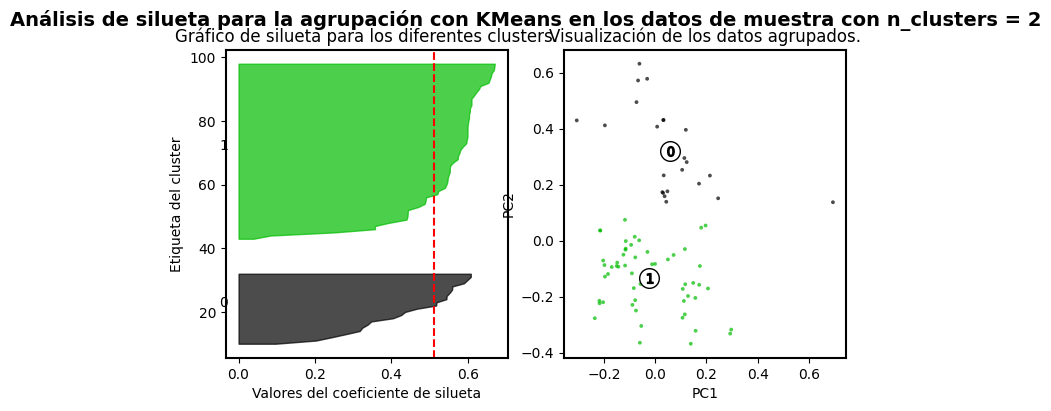

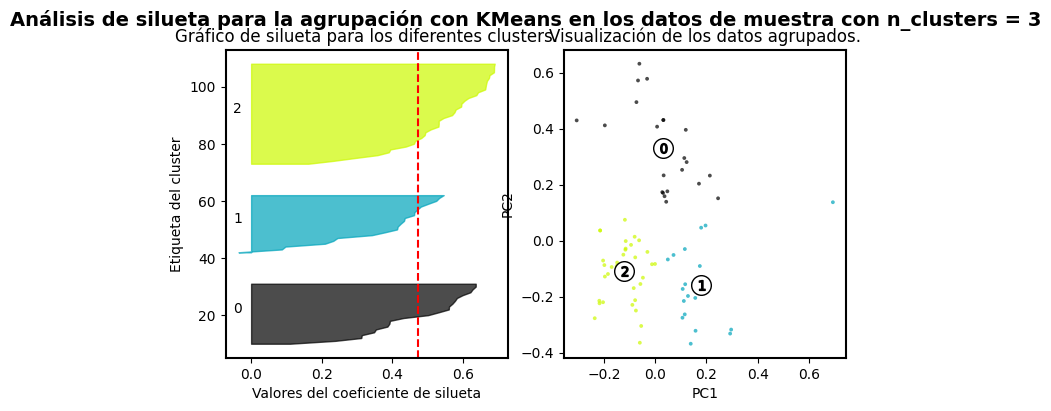

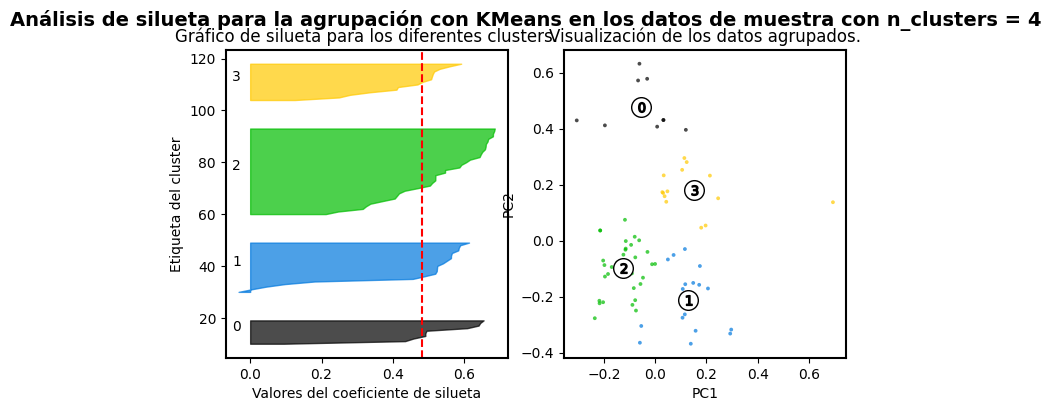

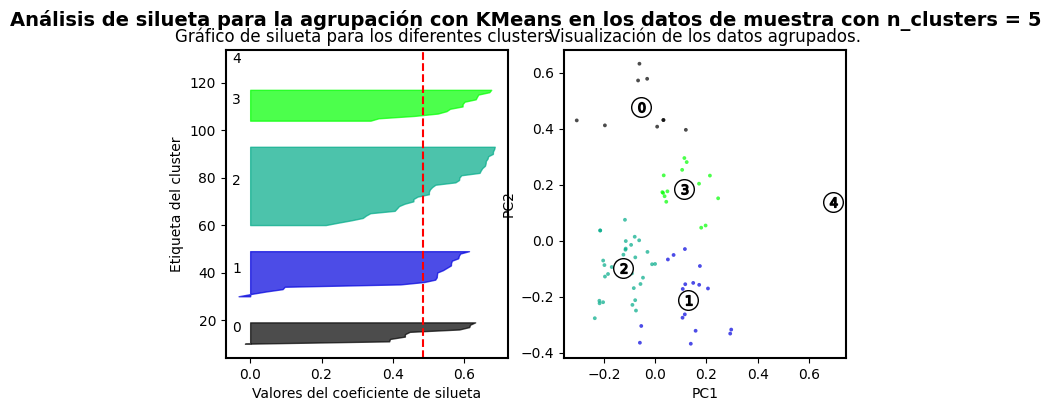

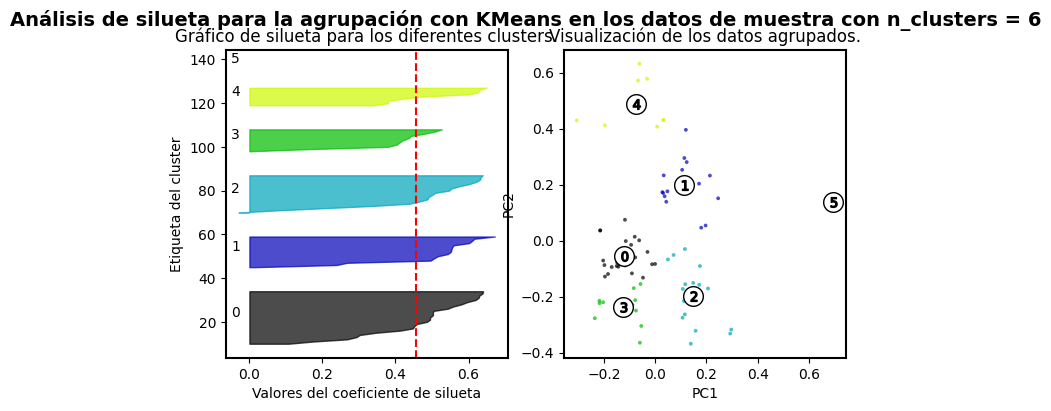

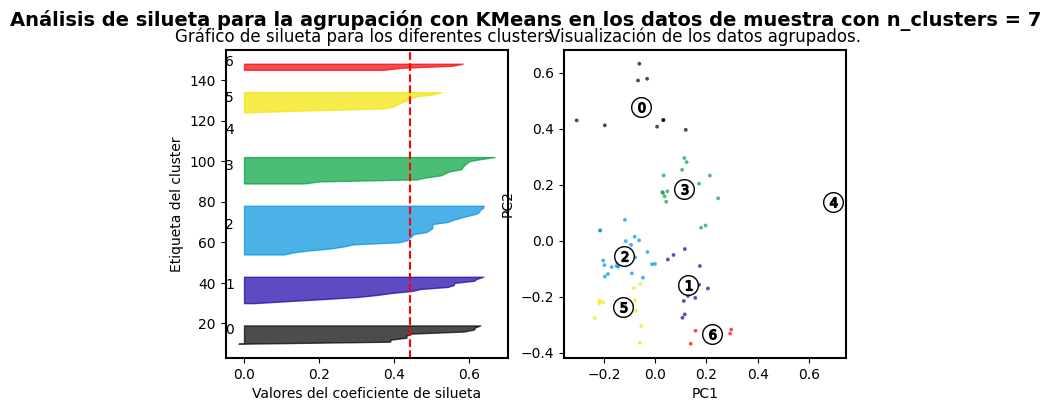

In [ ]:
# Silhouette analysis for different K numbers
# Figure configuration


for n_clusters in range_K_clusters:
    warnings.filterwarnings('ignore', category=FutureWarning)
    # Creamos una figura con dos subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(8, 4)

    # Creamos una instancia del algoritmo KMeans con el número de clusters deseado
    kmeans = KMeans(n_clusters=n_clusters, random_state=10)

    # Aplicamos el algoritmo a las componentes principales normalizadas
    cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized', 'PC2_normalized']])

    # Calculamos el coeficiente de silueta promedio para evaluar la calidad de los clusters
    silhouette_avg = silhouette_score(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El coeficiente de silueta promedio es:", silhouette_avg)

    # Calculamos los valores de silueta para cada muestra
    sample_silhouette_values = silhouette_samples(descriptors_pca[['PC1_normalized', 'PC2_normalized']], cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        # Agrupamos los valores de silueta para las muestras pertenecientes al cluster i y los ordenamos
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Definimos un color para el cluster i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Etiquetamos los gráficos de silueta con los números de cluster
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Calculamos el nuevo valor de y_lower para el próximo gráfico
        y_lower = y_upper + 10  # 10 para las muestras con valor 0

    # Configuramos el primer subplot (gráfico de silueta)
    ax1.set_title("Gráfico de silueta para los diferentes clusters.")
    ax1.set_xlabel("Valores del coeficiente de silueta")
    ax1.set_ylabel("Etiqueta del cluster")

    # Agregamos una línea vertical para el coeficiente de silueta promedio
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # Configuramos el segundo subplot (visualización de los clusters)
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Etiquetamos los clusters
    centers = kmeans.cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    # Iterar sobre los centroides de los clusters y graficarlos en el subplot ax2
    for i, c in enumerate(centers):
      ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Configurar título y etiquetas de los ejes del subplot ax2
      ax2.set_title("Visualización de los datos agrupados.")
      ax2.set_xlabel("PC1")
      ax2.set_ylabel("PC2")

    # Configurar título principal de la figura con información del análisis de silueta
    plt.suptitle(("Análisis de silueta para la agrupación con KMeans en los datos de muestra con n_clusters = %d" % n_clusters),
                              fontsize=14, fontweight='bold')

# Mostrar la figura completa
plt.show()

In [ ]:
#Defining cluster number
n_clusters = 5

In [ ]:
# Creating optimal k number
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Applying algorithm K means to the principal components with normalized values
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']])

# empty dataframe
cluster_info = pd.DataFrame()

cluster_info['ID'] = Activos_Resultados.index

# id cluster labels to the dataframe
cluster_info['cluster'] = clusters.labels_

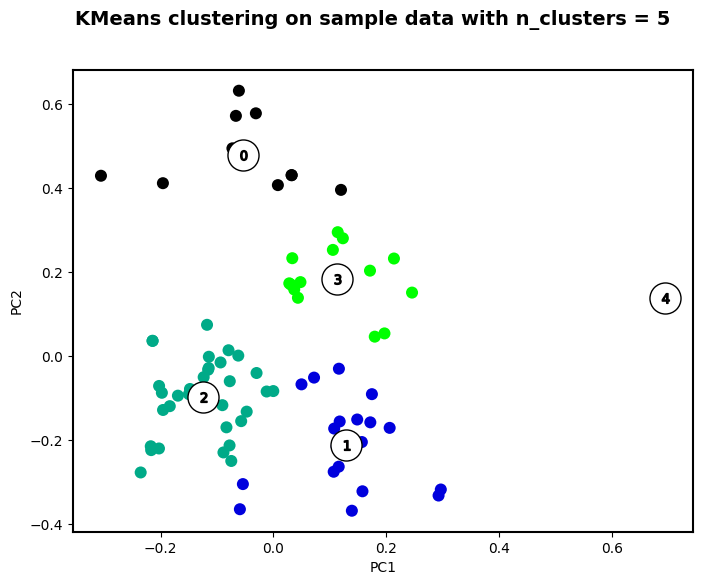

In [ ]:
#Create figure and subplot

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# Creamos una instancia del algoritmo K-means con el número de clústeres óptimo y una semilla aleatoria
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Aplicamos el algoritmo K-means a las componentes principales PC1 y PC2 (valores normalizados)
cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=300, lw=0, alpha=1,c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=500, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Establecemos las etiquetas de los ejes
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

# Título principal de la figura
plt.suptitle(("KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

# Guardamos la figura en un archivo
plt.savefig('KMeans_clustering.png')

# Mostramos la figura
plt.show()

In [ ]:

descriptors_pca['Cluster_PC1_PC2'] = clusters.labels_

# Adding cluster numbers in columns
Activos_Resultados['Cluster_PCA_5'] = clusters.labels_

In [ ]:
Activos_Resultados['Cluster_PCA_5'].unique()

array([1, 2, 3, 0, 4], dtype=int32)

In [ ]:
#separating each cluster in a different dataframe
Resultados_cluster_0 = Activos_Resultados[Activos_Resultados['Cluster_PCA_5'] == 0]
Resultados_cluster_1 = Activos_Resultados[Activos_Resultados['Cluster_PCA_5'] == 1]
Resultados_cluster_2 = Activos_Resultados[Activos_Resultados['Cluster_PCA_5'] == 2]
Resultados_cluster_3 = Activos_Resultados[Activos_Resultados['Cluster_PCA_5'] == 3]
Resultados_cluster_4 = Activos_Resultados[Activos_Resultados['Cluster_PCA_5'] == 4]

In [ ]:
#Defining cluster number
n_clusters = 2

In [ ]:
#Choosing optimal cluster number
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Applying algorithm K means to the principal components with normalized values
clusters = kmeans.fit(descriptors_pca[['PC1_normalized','PC2_normalized']])

# empty dataframe
cluster_info = pd.DataFrame()

cluster_info['ID'] = Activos_Resultados.index

# New cluster column
cluster_info['cluster'] = clusters.labels_

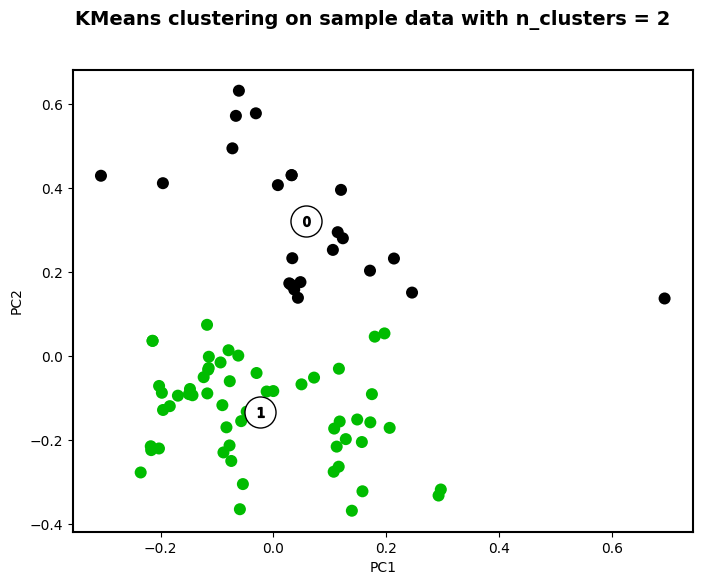

In [ ]:
#Creating figures
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

# Creamos una instancia del algoritmo K-means con el número de clústeres óptimo y una semilla aleatoria
kmeans = KMeans(n_clusters=n_clusters, random_state=10)

# Aplicamos el algoritmo K-means a las componentes principales PC1 y PC2 (valores normalizados)
cluster_labels = kmeans.fit_predict(descriptors_pca[['PC1_normalized','PC2_normalized']])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
plt.scatter(descriptors_pca['PC1_normalized'], descriptors_pca['PC2_normalized'],
                marker='.', s=300, lw=0, alpha=1,c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=500, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')
    # Establecemos las etiquetas de los ejes
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")

# Título principal de la figura
plt.suptitle(("KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

# Guardamos la figura en un archivo
plt.savefig('KMeans_clustering.png')

# Mostramos la figura
plt.show()

In [ ]:
# New column 'Cluster_PC1_PC2'
descriptors_pca['Cluster_PC1_PC2'] = clusters.labels_

# Another column 'clusters'
Activos_Resultados['Cluster_PCA_2'] = clusters.labels_

In [ ]:
Resultados.to_csv("Resultados_compuestos_lys_con_kmeans.csv") #gettning results in file csv
Activos_Resultados.to_csv("Resultados_activos_lys_con_kmeans.csv")

<Axes: xlabel='Cluster_PCA_5', ylabel='Count'>

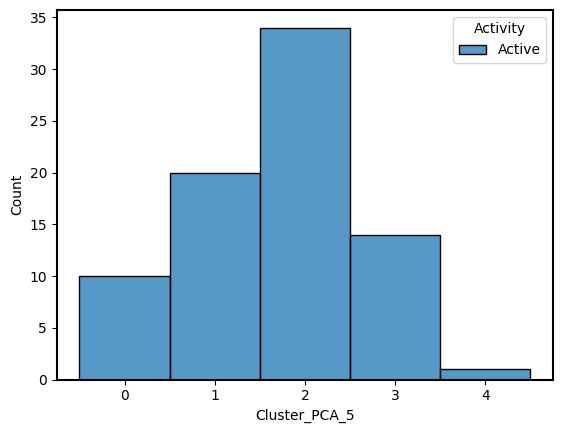

In [ ]:
sns.histplot(data=Activos_Resultados, x='Cluster_PCA_5', hue='Activity', multiple = "stack", discrete = True)

<Axes: xlabel='Cluster_PCA_2', ylabel='Count'>

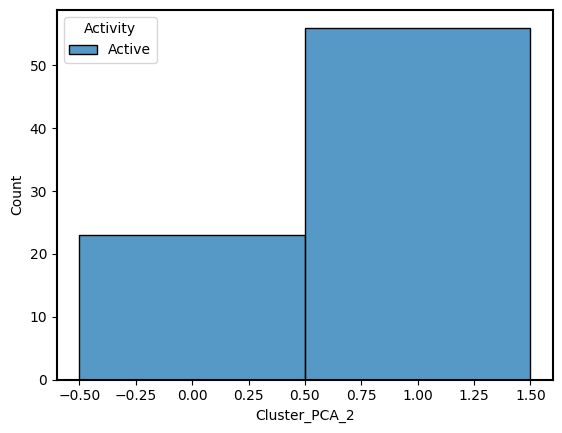

In [ ]:
sns.histplot(data=Activos_Resultados, x='Cluster_PCA_2', hue='Activity', multiple = "stack", discrete = True)

#Selection of negative molecules similar to the clusters

In order to create an optimal model to train it and predict activity/inactivity we decided to choose the negative/inactive molecules from the 60.000 compounds which were the most similar ones the the active compound. This was done so that the model can be trainedd in oret to efficently disstinguish betweeen both results.

In [ ]:
Resultados=pd.concat([df1,df2,df3,df4])

In [ ]:
Activos_Resultados #active ones

,index,canonical_smiles,ROMol,InchiKey,Activity,Organismo,assay_chembl_id,type,ID,Cluster_fingerprints,Cluster_PCA_5,Cluster_PCA_2
0,0,COc1cc(N2CCC(N3CCN(C)CC3)CC2)ccc1Nc1ncc(Cl)c(N...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f1b0>,QQWUGDVOUVUTOY-UHFFFAOYSA-N,Active,Human,CHEMBL1006347,IC50,0,0,1,1
1,1,Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1Cc2cnc(N)...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0eea0>,ZWVLMQTXUWMUII-UHFFFAOYSA-N,Active,Human,CHEMBL974011,EC50,1,0,2,1
2,4,CN(C)c1ccc(-c2cc3ncccc3c(NCCCCN)n2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0ed50>,SBGMPUIVPOGTGN-UHFFFAOYSA-N,Active,Human,CHEMBL1025770,IC50,2,0,2,1
3,5,CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0e2d0>,HKSZLNNOFSGOKW-FYTWVXJKSA-N,Active,Human,CHEMBL981176,IC50,3,0,1,1
4,6,COc1cc(Nc2nc(N[C@H]3CCCC[C@H]3N)n3nc(-c4ccccc4...,<rdkit.Chem.rdchem.Mol object at 0x7fdbf0d5cb30>,VLHKHLQNVJKAHG-UXHICEINSA-N,Active,Human,CHEMBL981176,IC50,4,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
74,403,C[C@@H]1CCC[C@H](C[C@H]2Cc3cc(O)cc(O)c3C(=O)O2)O1,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32500>,WOMKDMUZNBFXKG-OASPWFOLSA-N,Active,Plasmodium,CHEMBL4195366,IC50,74,0,2,1
75,410,C[C@H]1CCC[C@H](C[C@@H]2Cc3cc(O)cc(O)c3C(=O)O2)O1,<rdkit.Chem.rdchem.Mol object at 0x7fdba6b32810>,WOMKDMUZNBFXKG-BIMULSAOSA-N,Active,Plasmodium,CHEMBL4195366,IC50,75,0,2,1
76,69041,Cc1cccc(NC2CCc3c2[nH]c(=O)n(C2CCCCC2)c3=O)c1C,<rdkit.Chem.rdchem.Mol object at 0x7fdba63ef920>,VKLJGFUGCIOKKO-UHFFFAOYSA-N,Active,Plasmodium,CHEMBL4649943,pIC50,76,0,2,1
77,69127,Nc1ncc2c(n1)CN(C1CCCC1)C2=O,<rdkit.Chem.rdchem.Mol object at 0x7fdba63f5f50>,RUUUZPDEYNEEEZ-UHFFFAOYSA-N,Active,Plasmodium,CHEMBL4649943,pIC50,77,0,0,0


In [ ]:
Inactivos_Resultados #inactive

,index,canonical_smiles,ROMol,InchiKey,Activity,Organismo,assay_chembl_id,type,ID
0,9,COc1cc(Nc2nc(N[C@H]3CCCC[C@H]3N)n3c(-c4ccccc4)...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0e420>,JTSSFGDEGJQWBU-UXHICEINSA-N,Inactive,Human,CHEMBL981176,IC50,0
1,15,COc1cc(Nc2nc(NCC(=O)OC(C)(C)C)n3cnnc3c2C(N)=O)...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f0d0>,BUMDSUVAQUFGCD-UHFFFAOYSA-N,Inactive,Human,CHEMBL981176,IC50,1
2,22,COc1cc(Nc2nc(N(C)Cc3ccccc3)n3ccnc3c2C(N)=O)cc(...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f6f0>,WRTLOLDYSMFKTE-UHFFFAOYSA-N,Inactive,Human,CHEMBL1020473,IC50,2
3,26,COc1ccc(CNc2nc(Nc3cc(OC)cc(OC)c3)c(C(N)=O)c3nc...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0f920>,FLXGGVDRCLMNRL-UHFFFAOYSA-N,Inactive,Human,CHEMBL1020473,IC50,3
4,34,COc1cc(Nc2nc(NCc3ccc(S(C)(=O)=O)cc3)n3ccnc3c2C...,<rdkit.Chem.rdchem.Mol object at 0x7fdba7a0fd10>,AVBQIXRIBVZIBA-UHFFFAOYSA-N,Inactive,Human,CHEMBL1020473,IC50,4
...,...,...,...,...,...,...,...,...,...
69039,68974,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0970>,QXUBWQVELITOIY-OKZTUQRJSA-N,Inactive,Plasmodium,NaN,NaN,69039
69040,68975,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f09e0>,NZIAYXBYYLQTQI-APTPAJQOSA-N,Inactive,Plasmodium,NaN,NaN,69040
69041,68976,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0a50>,KQPDTOXIHCTWNQ-CTHHTMFSSA-N,Inactive,Plasmodium,NaN,NaN,69041
69042,68977,NaN,<rdkit.Chem.rdchem.Mol object at 0x7fdba16f0ac0>,TXIXAMVGDAEWNX-LFELFHSZSA-N,Inactive,Plasmodium,NaN,NaN,69042


In [ ]:
Resultados_cluster_0 = Activos_Resultados[Activos_Resultados['Cluster_PCA_2'] == 0]
Resultados_cluster_1 = Activos_Resultados[Activos_Resultados['Cluster_PCA_2'] == 1]

For cluster 0:

In [ ]:
# Creating a list of fingerprints for each molecule in the R0mol column
fps_activos = [FingerprintMols.FingerprintMol(mol) for mol in Resultados_cluster_0['ROMol']]
fps_activos = [FingerprintMols.FingerprintMol(mol) for mol in Resultados_cluster_1['ROMol']]
fp_list = []
for i in range(len(Inactivos_Resultados)):
  mol= Inactivos_Resultados['ROMol'][i]
  fp = FingerprintMols.FingerprintMol(mol)
  fp_list.append(fp)
fps_inactivos = [FingerprintMols.FingerprintMol(mol) for mol in Inactivos_Resultados['ROMol']]

In [ ]:
# fOR Warnings
warnings.filterwarnings('ignore')

size_molport = len(fps_activos)
size_Enamine = len(fps_inactivos)

# empty array to put the similarity matrix
hmap = np.empty(shape=(size_molport, size_Enamine))
#empty dataframe
table = pd.DataFrame()

# Iteration on each row
for i in range(len(fps_activos)):
    # Iteration on each column
    for j in range(len(fps_inactivos)):
        #Calculating fingerprints similarity between fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps_activos[i], fps_inactivos[j])
        # Keeping similarity on the matrix
        hmap[i, j] = similarity
        # Adding similarity to the table with their corresponding id
        table.loc[Resultados_cluster_0['ROCS_Rank'][i], Inactivos_Resultados['ID'][j]] = similarity

In [ ]:
#Here we kept the most similar compounds so we took the ones who were  > 0.8  as 1 is perfectly similar

list_high_molecules_8 = []
for i in range(1,len(Resultados_cluster_0)):
  for j in range(len(Inactivos_Resultados)):
    if table.at[i,j] > 0.8:
      molecule = i
      list_high_molecules_8.append(molecule)
    else:
      pass

print(list_high_molecules_8)

For cluster 1:

In [ ]:
# Warings
warnings.filterwarnings('ignore')

size_molport = len(fps_activos)
size_Enamine = len(fps_inactivos)

# empty array to put the similarity matrix
hmap = np.empty(shape=(size_molport, size_Enamine))

# empty dataframe
table = pd.DataFrame()

# Iteration on each row
for i in range(len(fps_activos)):
    # Iteration on each column
    for j in range(len(fps_inactivos)):
         # Calculagting fingerprints similarity between fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps_activos[i], fps_inactivos[j])
        # Keeping similarity on matrix
        hmap[i, j] = similarity
       # Adding similarity to the table with their corresponding id
        table.loc[Resultados_cluster_1['ROCS_Rank'][i], Inactivos_Resultados['ID'][j]] = similarity

In [ ]:
list_high_molecules_8 = []
for i in range(1,len(Resultados_cluster_1)):
  for j in range(len(Inactivos_Resultados)):
    if table.at[i,j] > 0.8:
      molecule = i
      list_high_molecules_8.append(molecule)
    else:
      pass

print(list_high_molecules_8)